# Code to generate the figure for the forgotten puzzle example

In [1]:
import pickle
import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_logit_lens import LeelaLogitLens
import leela_interp.tools.figure_helpers as fh
from leela_logit_lens.tools.utils import get_top_k_moves
from leela_logit_lens.tools.plotting_helpers import make_translucent_arrows, PolicyBarWithColors

## STEP 1: LOAD PUZZLE AND EVALUATE WITH LOGIT LENS

In [2]:
print("Loading puzzles...")
with open("../data/interesting_puzzles_history.pkl", "rb") as f:
    puzzles = pickle.load(f)

Loading puzzles...


In [3]:
# Select puzzle 58Ib0
puzzle = puzzles[puzzles['PuzzleId'] == '58Ib0'].iloc[0]
# puzzle = puzzles[puzzles['PuzzleId'] == 'BIppU'].iloc[0]
print(f"\nPuzzle ID: {puzzle['PuzzleId']}")
print(f"FEN: {puzzle['FEN']}")
print(f"Solution moves: {puzzle['Moves']}")
print(f"Principal variation: {puzzle['principal_variation']}")


Puzzle ID: 58Ib0
FEN: 8/p1p2ppk/2p2q1p/3p4/P3bP1P/1P4R1/2P2Q2/6K1 b - - 1 33
Solution moves: f6h4 g3g7 h7g7 f2h4
Principal variation: ['g3g7', 'h7g7', 'f2h4']



Board position:


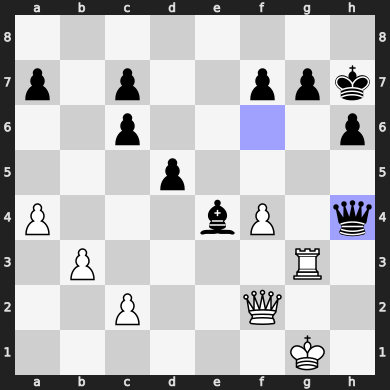

In [4]:
# Create board from puzzle
board = LeelaBoard.from_pgn(puzzle['Puzzle_PGN'])
print(f"\nBoard position:")
board

In [5]:
# Load model and logit lens
print("\nLoading model...")
model = Lc0sight("../lc0-original.onnx")
lens = LeelaLogitLens(model=model)


Loading model...
Using device: cpu


In [6]:
# Evaluate with logit lens
print("\nEvaluating with logit lens...")
results = lens.multi_layer_lens(board, output="policy", return_probs=True, return_policy_as_dict=True)


Evaluating with logit lens...


/Users/hartig/PycharmProjects/leela-logit-lens-paper/venv/lib/python3.13/site-packages/onnx2torch/node_converters/slice.py:63: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_variable_indexing.cpp:312.)
  x = x[pos_axes_slices]


### IDENTIFY WINNING AND LOSING MOVES

In [7]:
# Winning move: first move in principal variation (puzzle solution)
winning_move_uci = puzzle.principal_variation[0]
winning_move_san = board.pc_board.san(chess.Move.from_uci(winning_move_uci))
print(f"\nWinning move: {winning_move_san} ({winning_move_uci})")


Winning move: Rxg7+ (g3g7)


In [8]:
# Losing move: top move from final output (if different from winning move)
final_policy = results[0]['layers'][15]['policy_as_dict']
top_final_move = get_top_k_moves(final_policy, k=1)[0][0]
losing_move_uci = top_final_move if top_final_move != winning_move_uci else get_top_k_moves(final_policy, k=2)[1][0]
losing_move_san = board.pc_board.san(chess.Move.from_uci(losing_move_uci))
print(f"Losing move (final output top): {losing_move_san} ({losing_move_uci})")

Losing move (final output top): Kf1 (g1f1)


### EXTRACT PROBABILITY TRAJECTORIES FOR ALL MOVES

In [9]:
# Layer indices: 0=Input, 1=Layer 0, ..., 14=Layer 13, 15=Final
layer_indices = list(range(16))  # 0 through 15
layer_labels = ['Input'] + [str(i) for i in range(14)] + ['Final']

In [10]:
# Get all legal moves
all_moves = list(results[0]['layers'][0]['policy_as_dict'].keys())
print(f"\nTotal legal moves: {len(all_moves)}")


Total legal moves: 28


In [11]:
# Extract probabilities for each move across all layers
move_trajectories = {}
for move_uci in all_moves:
    trajectory = []
    for layer_idx in layer_indices:
        policy = results[0]['layers'][layer_idx]['policy_as_dict']
        prob = policy.get(move_uci, 0.0)
        trajectory.append(prob)
    move_trajectories[move_uci] = trajectory

### CREATE PROBABILITY TRAJECTORY PLOT


Creating probability trajectory plot...


<>:58: SyntaxWarning: invalid escape sequence '\%'
<>:58: SyntaxWarning: invalid escape sequence '\%'
/var/folders/8f/my3yq2094v3c99jtb3vbvk4s3t9d3w/T/ipykernel_86595/3686183661.py:58: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Probability (\%)')



Trajectory plot created!


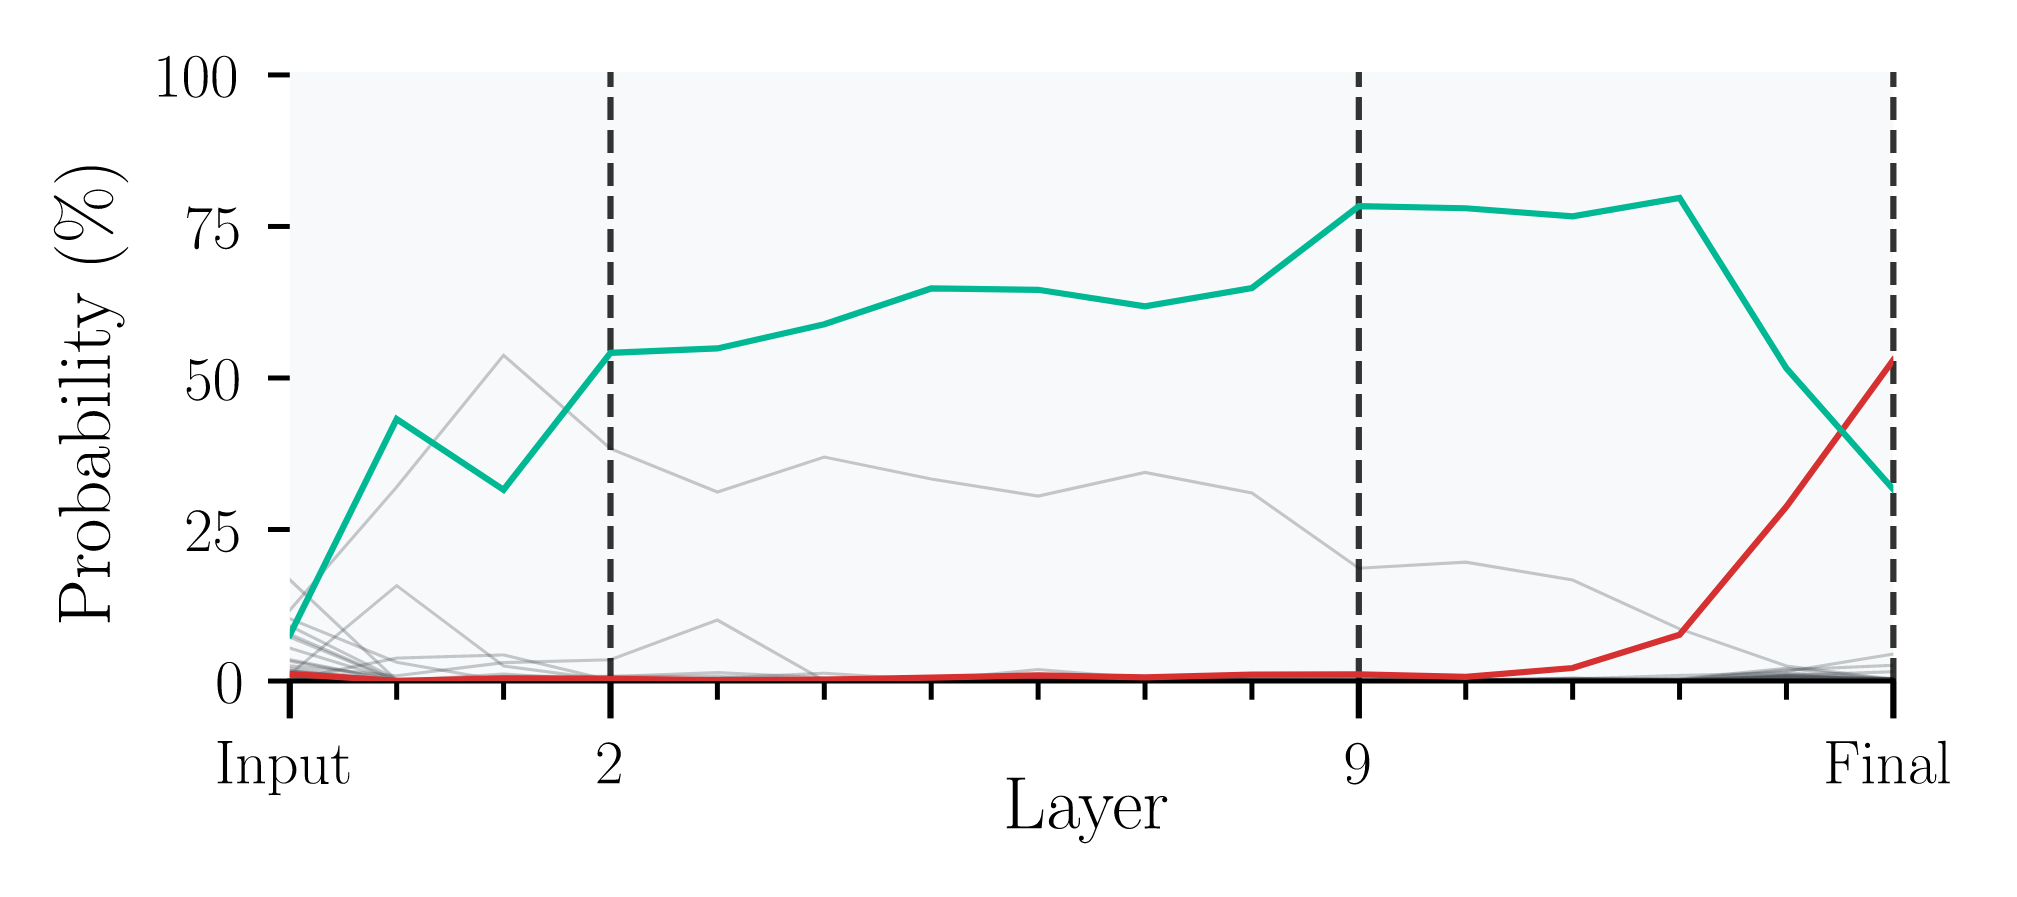

<Figure size 640x480 with 0 Axes>

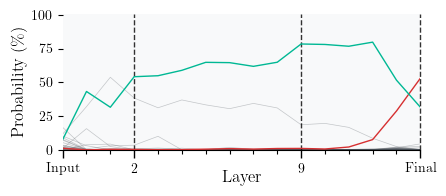

In [12]:
print("\nCreating probability trajectory plot...")

import matplotlib.patheffects as pe

# Set up matplotlib style (matching example)
plt.ioff()
plt.gcf().clear()
fh.set()

BIGGER_SIZE = 12
MEDIUM_SIZE = 10
SMALLER_SIZE = 8 
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=MEDIUM_SIZE)
plt.rc("ytick", labelsize=MEDIUM_SIZE)

fig, ax = plt.subplots()
fig.set_figwidth(4.5)
fig.set_figheight(2)

# Plot grey lines for all other moves
for move_uci, trajectory in move_trajectories.items():
    if move_uci not in [winning_move_uci, losing_move_uci]:
        ax.plot(
            layer_indices,
            [p * 100 for p in trajectory],  # Convert to percentage
            color=fh.COLORS[3],  # Grey
            alpha=0.3,
            linewidth=fh.LINE_WIDTH,
            zorder=1
        )

# Plot red line for losing move
losing_trajectory = move_trajectories[losing_move_uci]
ax.plot(
    layer_indices,
    [p * 100 for p in losing_trajectory],
    color=fh.COLORS[2],  # Red
    linewidth=1,
    label='Losing move',
    zorder=3
)

# Plot green line for winning move
winning_trajectory = move_trajectories[winning_move_uci]
ax.plot(
    layer_indices,
    [p * 100 for p in winning_trajectory],
    color=fh.COLORS[0],  # Green
    linewidth=1,
    label='Winning move',
    zorder=3
)

# Styling (matching example)
ax.set_xlabel('Layer', labelpad=-3)
ax.set_ylabel('Probability (\%)')
# ax.set_xlim(-0.0, 15.5)
ax.set_xlim(-0.0, 15)
# ax.set_ylim(0, 105)
ax.set_ylim(0, 100.5)

# X-ticks: Include layers where we'll show boards (2, 10, Final=15) plus some in between
# Using: Input, 2, 4, 6, 8, 10, 12, 14, Final
# tick_indices = [0, 3, 6, 9, 12, 15]
tick_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
tick_indices_to_plot = [0, 3, 10, 15]

ax.set_yticks([0, 25, 50, 75, 100])

# Major ticks: labeled
ax.set_xticks(tick_indices_to_plot)
ax.set_xticklabels([layer_labels[i] for i in tick_indices_to_plot])

# Minor ticks: unlabeled positions (everything else)
tick_indices = list(range(16))  # 0..15
minor_ticks = [i for i in tick_indices if i not in tick_indices_to_plot]
ax.set_xticks(minor_ticks, minor=True)

# Style: make major ticks longer/thicker, minor ticks shorter/thinner
ax.tick_params(axis='x', which='major', length=6, width=1.0)
ax.tick_params(axis='x', which='minor', length=3, width=0.8, labelsize=0)

# Add dashed vertical lines at board snapshot layers
board_layers = [3, 10, 15]  # Layer 2, Layer 9, Final
for layer in board_layers:
    ax.axvline(x=layer, color='k', linestyle='--', alpha=0.8, linewidth=1, clip_on=False)

ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_facecolor(fh.PLOT_FACE_COLOR)
fig.patch.set_alpha(0)

plt.tight_layout()

# Convert to iceberg
plot_ice = ice.MatplotlibFigure(figure=fig)
print("\nTrajectory plot created!")

# Display the plot
plot_ice.scale(5)

#### Same with small poster annotation


Creating probability trajectory plot...

Trajectory plot created!


<>:92: SyntaxWarning: invalid escape sequence '\%'
<>:92: SyntaxWarning: invalid escape sequence '\%'
/var/folders/8f/my3yq2094v3c99jtb3vbvk4s3t9d3w/T/ipykernel_86595/4149085125.py:92: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Probability (\%)')


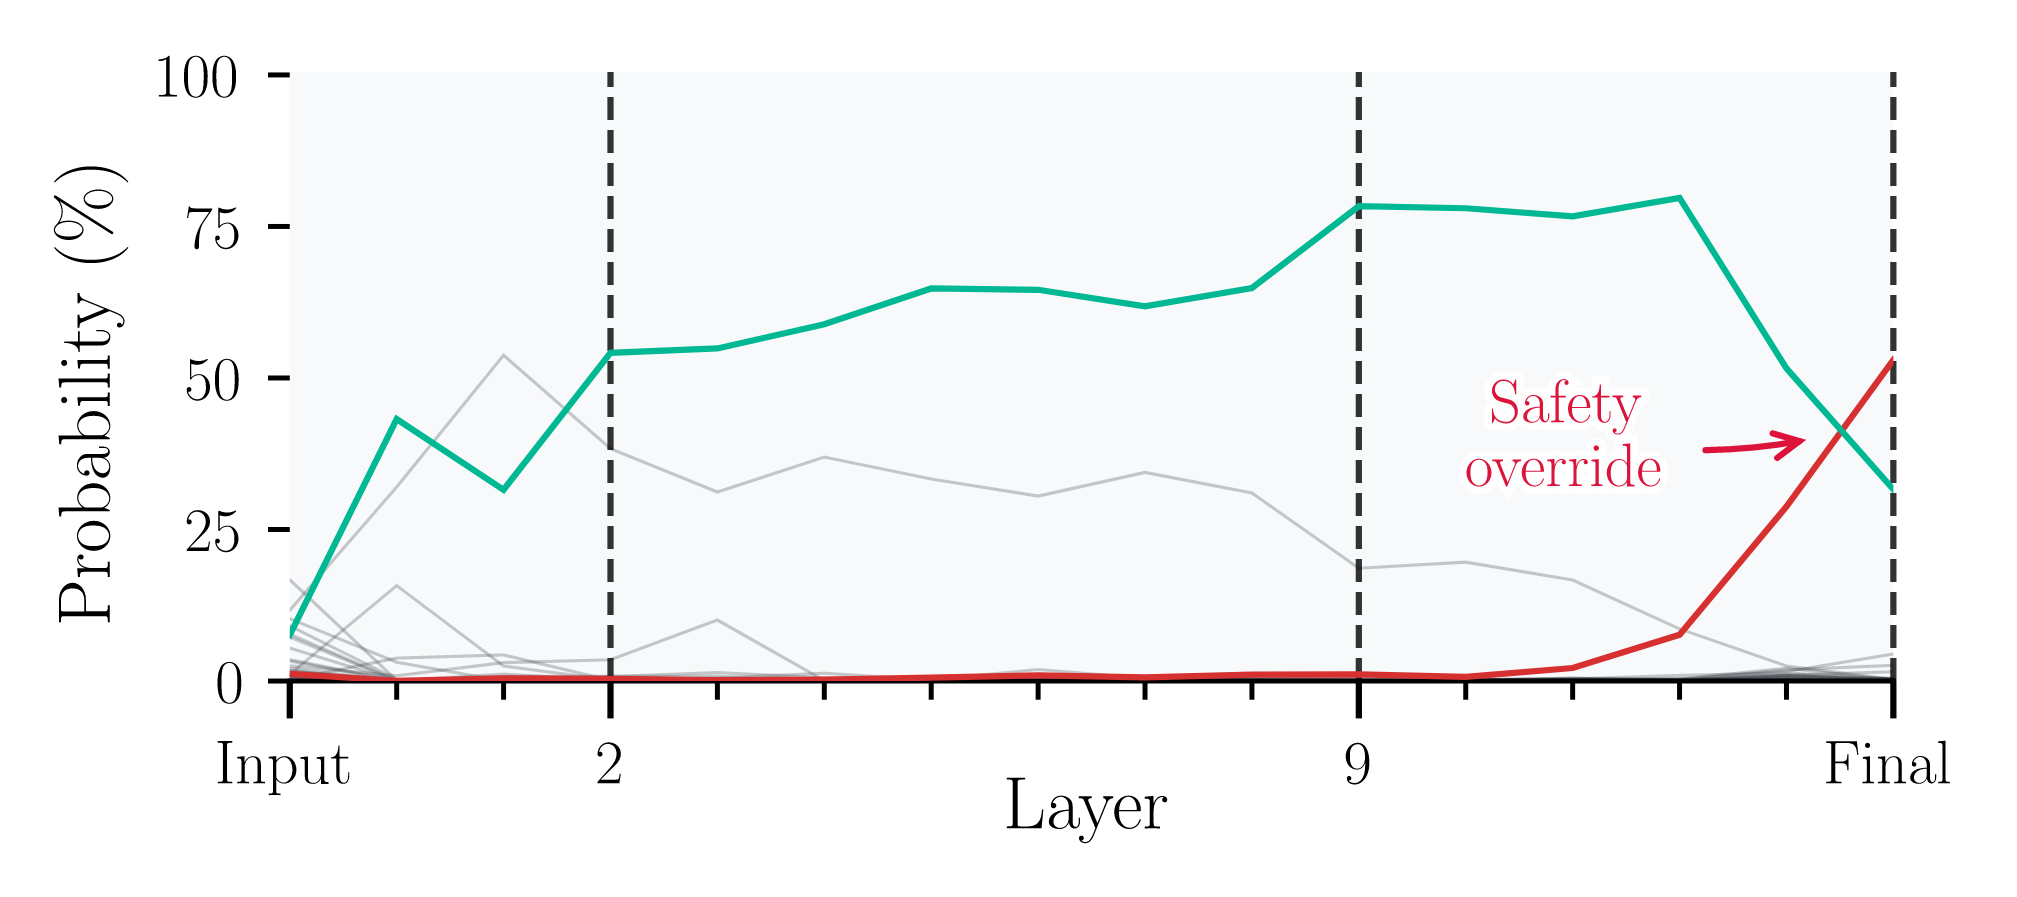

In [13]:
print("\nCreating probability trajectory plot...")

import matplotlib.patheffects as pe

# Set up matplotlib style (matching example)
plt.ioff()
plt.gcf().clear()
fh.set()

BIGGER_SIZE = 12
MEDIUM_SIZE = 10
SMALLER_SIZE = 8 
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=MEDIUM_SIZE)
plt.rc("ytick", labelsize=MEDIUM_SIZE)

fig, ax = plt.subplots()
fig.set_figwidth(4.5)
fig.set_figheight(2)

# Plot grey lines for all other moves
for move_uci, trajectory in move_trajectories.items():
    if move_uci not in [winning_move_uci, losing_move_uci]:
        ax.plot(
            layer_indices,
            [p * 100 for p in trajectory],  # Convert to percentage
            color=fh.COLORS[3],  # Grey
            alpha=0.3,
            linewidth=fh.LINE_WIDTH,
            zorder=1
        )

# Plot red line for losing move
losing_trajectory = move_trajectories[losing_move_uci]
ax.plot(
    layer_indices,
    [p * 100 for p in losing_trajectory],
    color=fh.COLORS[2],  # Red
    linewidth=1,
    label='Losing move',
    zorder=3
)

# Plot green line for winning move
winning_trajectory = move_trajectories[winning_move_uci]
ax.plot(
    layer_indices,
    [p * 100 for p in winning_trajectory],
    color=fh.COLORS[0],  # Green
    linewidth=1,
    label='Winning move',
    zorder=3
)

# Add "Safety override" annotation at crossover point
# Find approximate crossover point (where red > green, around layer 13-14)
crossover_x = 14.3
crossover_y = (losing_trajectory[14] * 100 + winning_trajectory[14] * 100) / 2  # Midpoint between lines

# Annotation position (to the right, in clear space)
annotation_x = 12
annotation_y = 40

ann = ax.annotate(
    'Safety\noverride',
    xy=(crossover_x, crossover_y),
    xytext=(annotation_x, annotation_y),
    fontsize=10,
    color='#DC143C',  # Crimson
    ha='center',
    va='center',
    arrowprops=dict(
        arrowstyle='->',
        color='#DC143C',
        lw=1,
        connectionstyle='arc3,rad=0.1',
        mutation_scale=10 

    ),
    zorder=20
)

# Add white outline
ann.set_path_effects([
    pe.withStroke(linewidth=2.5, foreground="white", alpha=0.9)
])


# Styling (matching example)
ax.set_xlabel('Layer', labelpad=-3)
ax.set_ylabel('Probability (\%)')
# ax.set_xlim(-0.0, 15.5)
ax.set_xlim(-0.0, 15)
# ax.set_ylim(0, 105)
ax.set_ylim(0, 100.5)

# X-ticks: Include layers where we'll show boards (2, 10, Final=15) plus some in between
# Using: Input, 2, 4, 6, 8, 10, 12, 14, Final
# tick_indices = [0, 3, 6, 9, 12, 15]
tick_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
tick_indices_to_plot = [0, 3, 10, 15]

ax.set_yticks([0, 25, 50, 75, 100])

# Major ticks: labeled
ax.set_xticks(tick_indices_to_plot)
ax.set_xticklabels([layer_labels[i] for i in tick_indices_to_plot])

# Minor ticks: unlabeled positions (everything else)
tick_indices = list(range(16))  # 0..15
minor_ticks = [i for i in tick_indices if i not in tick_indices_to_plot]
ax.set_xticks(minor_ticks, minor=True)

# Style: make major ticks longer/thicker, minor ticks shorter/thinner
ax.tick_params(axis='x', which='major', length=6, width=1.0)
ax.tick_params(axis='x', which='minor', length=3, width=0.8, labelsize=0)

# Add dashed vertical lines at board snapshot layers
board_layers = [3, 10, 15]  # Layer 2, Layer 9, Final
for layer in board_layers:
    ax.axvline(x=layer, color='k', linestyle='--', alpha=0.8, linewidth=1, clip_on=False)

ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_facecolor(fh.PLOT_FACE_COLOR)
fig.patch.set_alpha(0)

plt.tight_layout()

# Convert to iceberg
plot_ice_annotated = ice.MatplotlibFigure(figure=fig)
print("\nTrajectory plot created!")

# Display the plot
plot_ice_annotated.scale(5)

### STEP 2: CREATE THREE BOARD SNAPSHOTS

In [14]:
layer_labels_long = ['Input encoding'] + ['Layer ' + str(i) for i in range(14)] + ['Model output']


Creating board snapshots...
  Created Layer Layer 2 board
  Created Layer Layer 9 board
  Created Layer Model output board

Board snapshots created!


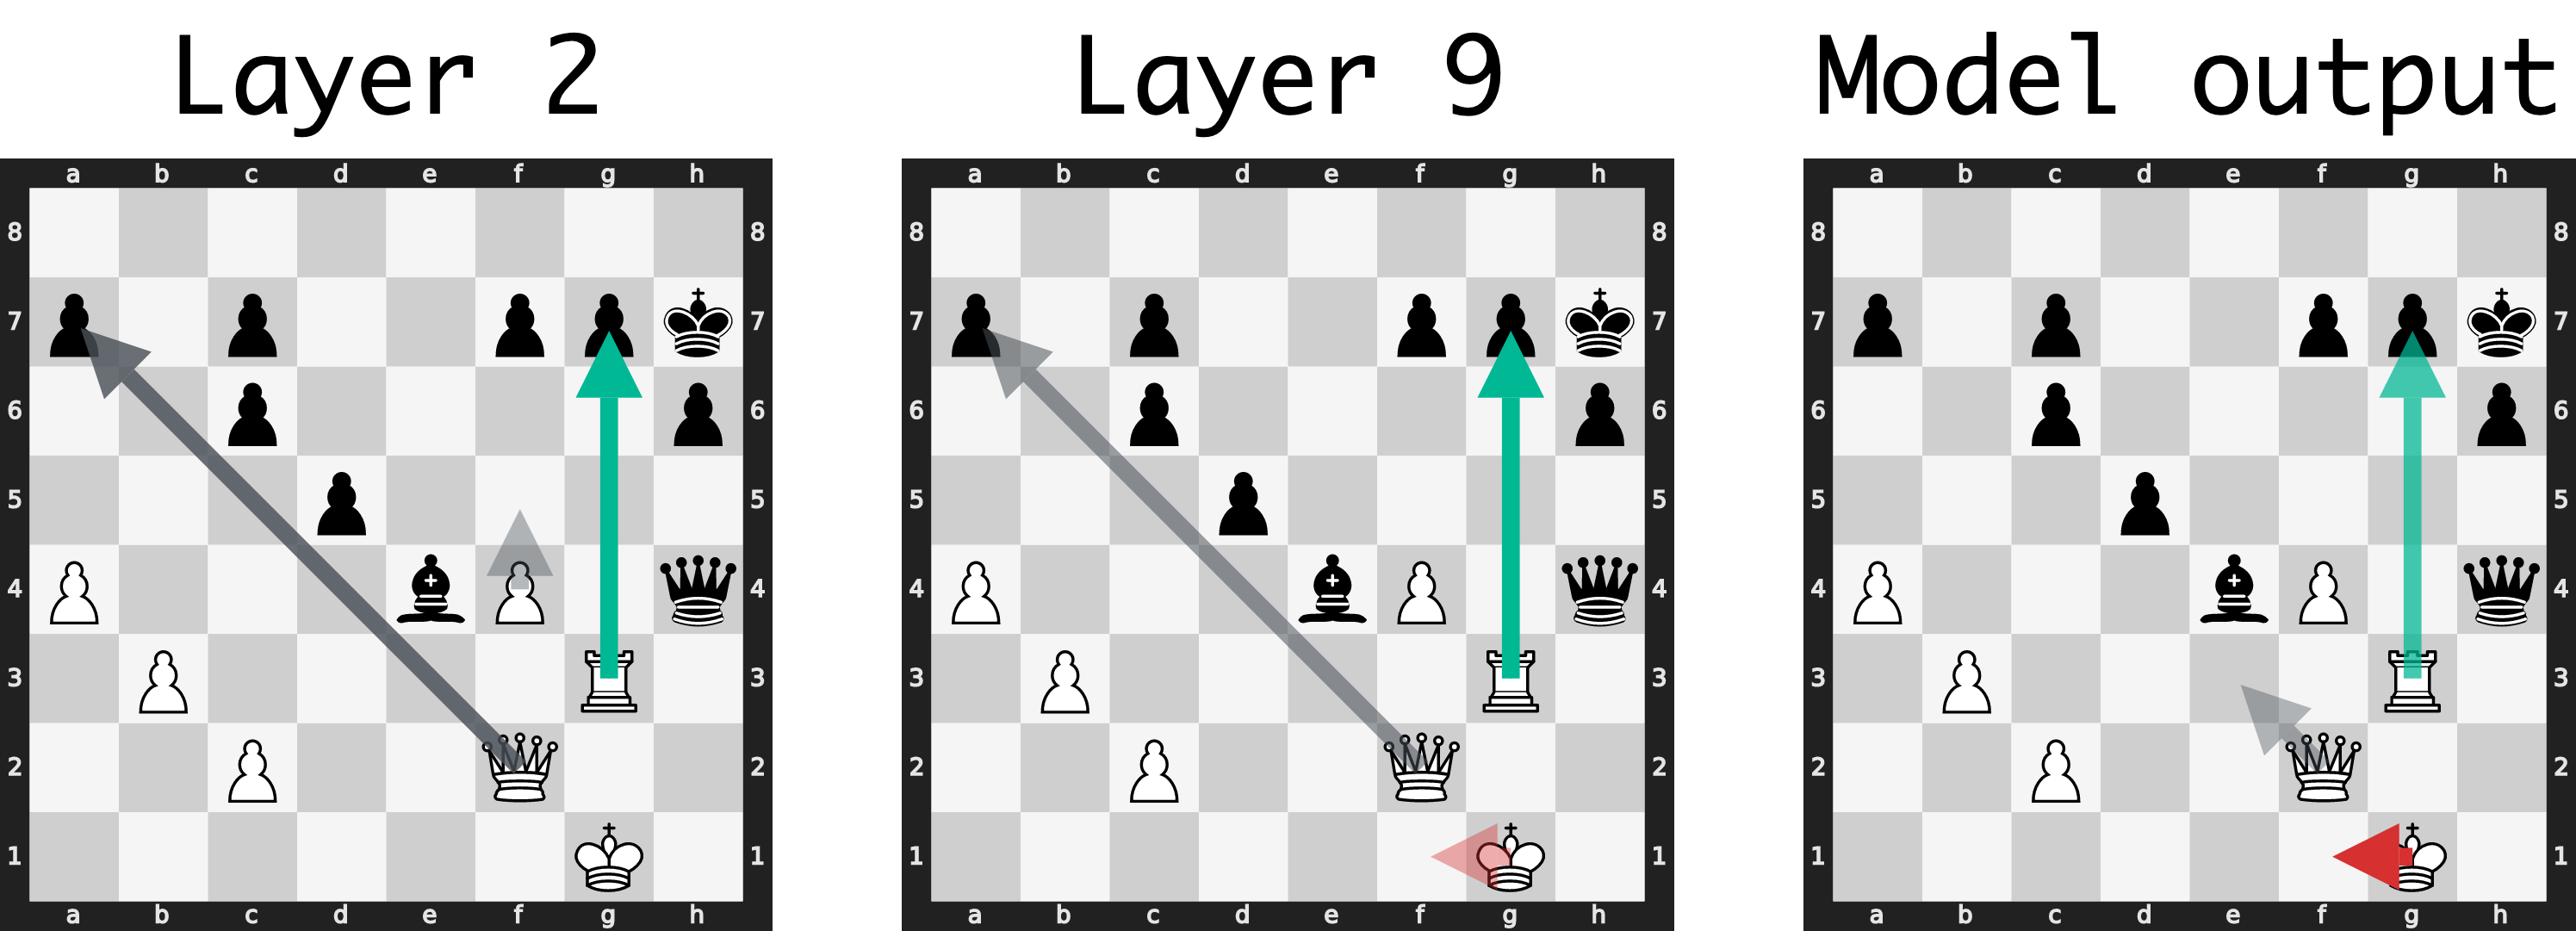

In [15]:
print("\nCreating board snapshots...")

# Use the same board_layers defined earlier for consistency
snapshot_layers = board_layers  # [3, 10, 15] = Layer 2, Layer 9, Final
snapshot_names = [layer_labels_long[i] for i in snapshot_layers]  # ["2", "9", "Final"]

# Color scheme for moves
move_colors = [
    ice.Color.from_hex(fh.COLORS[0]),  # green - winning
    ice.Color.from_hex(fh.COLORS[2]),  # red - losing
    ice.Color.from_hex(fh.COLORS[3]),  # grey - other
]

board_snapshots = []

for layer_idx, layer_name in zip(snapshot_layers, snapshot_names):
    # Get policy for this layer
    layer_policy = results[0]['layers'][layer_idx]['policy_as_dict']
    
    # Get top-3 moves
    top_3_moves = get_top_k_moves(layer_policy, k=3)
    
    # Assign colors based on whether moves are winning/losing/other
    arrows_dict = {}
    colors_for_arrows = []
    
    for i, (move_uci, prob) in enumerate(top_3_moves):
        if move_uci == winning_move_uci:
            colors_for_arrows.append(move_colors[0])  # green
        elif move_uci == losing_move_uci:
            colors_for_arrows.append(move_colors[1])  # red
        else:
            colors_for_arrows.append(move_colors[2])  # grey
    
    # Create translucent arrows for this layer
    arrows_for_board = make_translucent_arrows(
        policy_as_dict={move: prob for move, prob in top_3_moves},
        k=3,
        colors=colors_for_arrows
    )
    
    # Create board plot with arrows
    board_plot = board.plot(
        arrows=arrows_for_board,
        show_lastmove=False
    ).scale(2.3)
    
    # Add title ABOVE the board
    title = ice.Text(f"{layer_name}", ice.FontStyle("Monaco", size=120)).pad(12)
    
    # Arrange title above board
    board_with_title = title + board_plot.relative_to(title, ice.TOP_MIDDLE, ice.BOTTOM_MIDDLE)
    
    # Crop to remove extra whitespace
    board_with_title = board_with_title.crop(board_with_title.bounds)
    board_snapshots.append(board_with_title)
    
    print(f"  Created Layer {layer_name} board")

# Arrange the 3 boards horizontally with more spacing
boards_row = ice.Arrange(board_snapshots, gap=150, arrange_direction=ice.HORIZONTAL)

print("\nBoard snapshots created!")

boards_row

### STEP 3: ARRANGE BOARDS WITH TRAJECTORY AND ADD CONNECTING LINES


Arranging boards with trajectory plot...

Connected boards to trajectory!


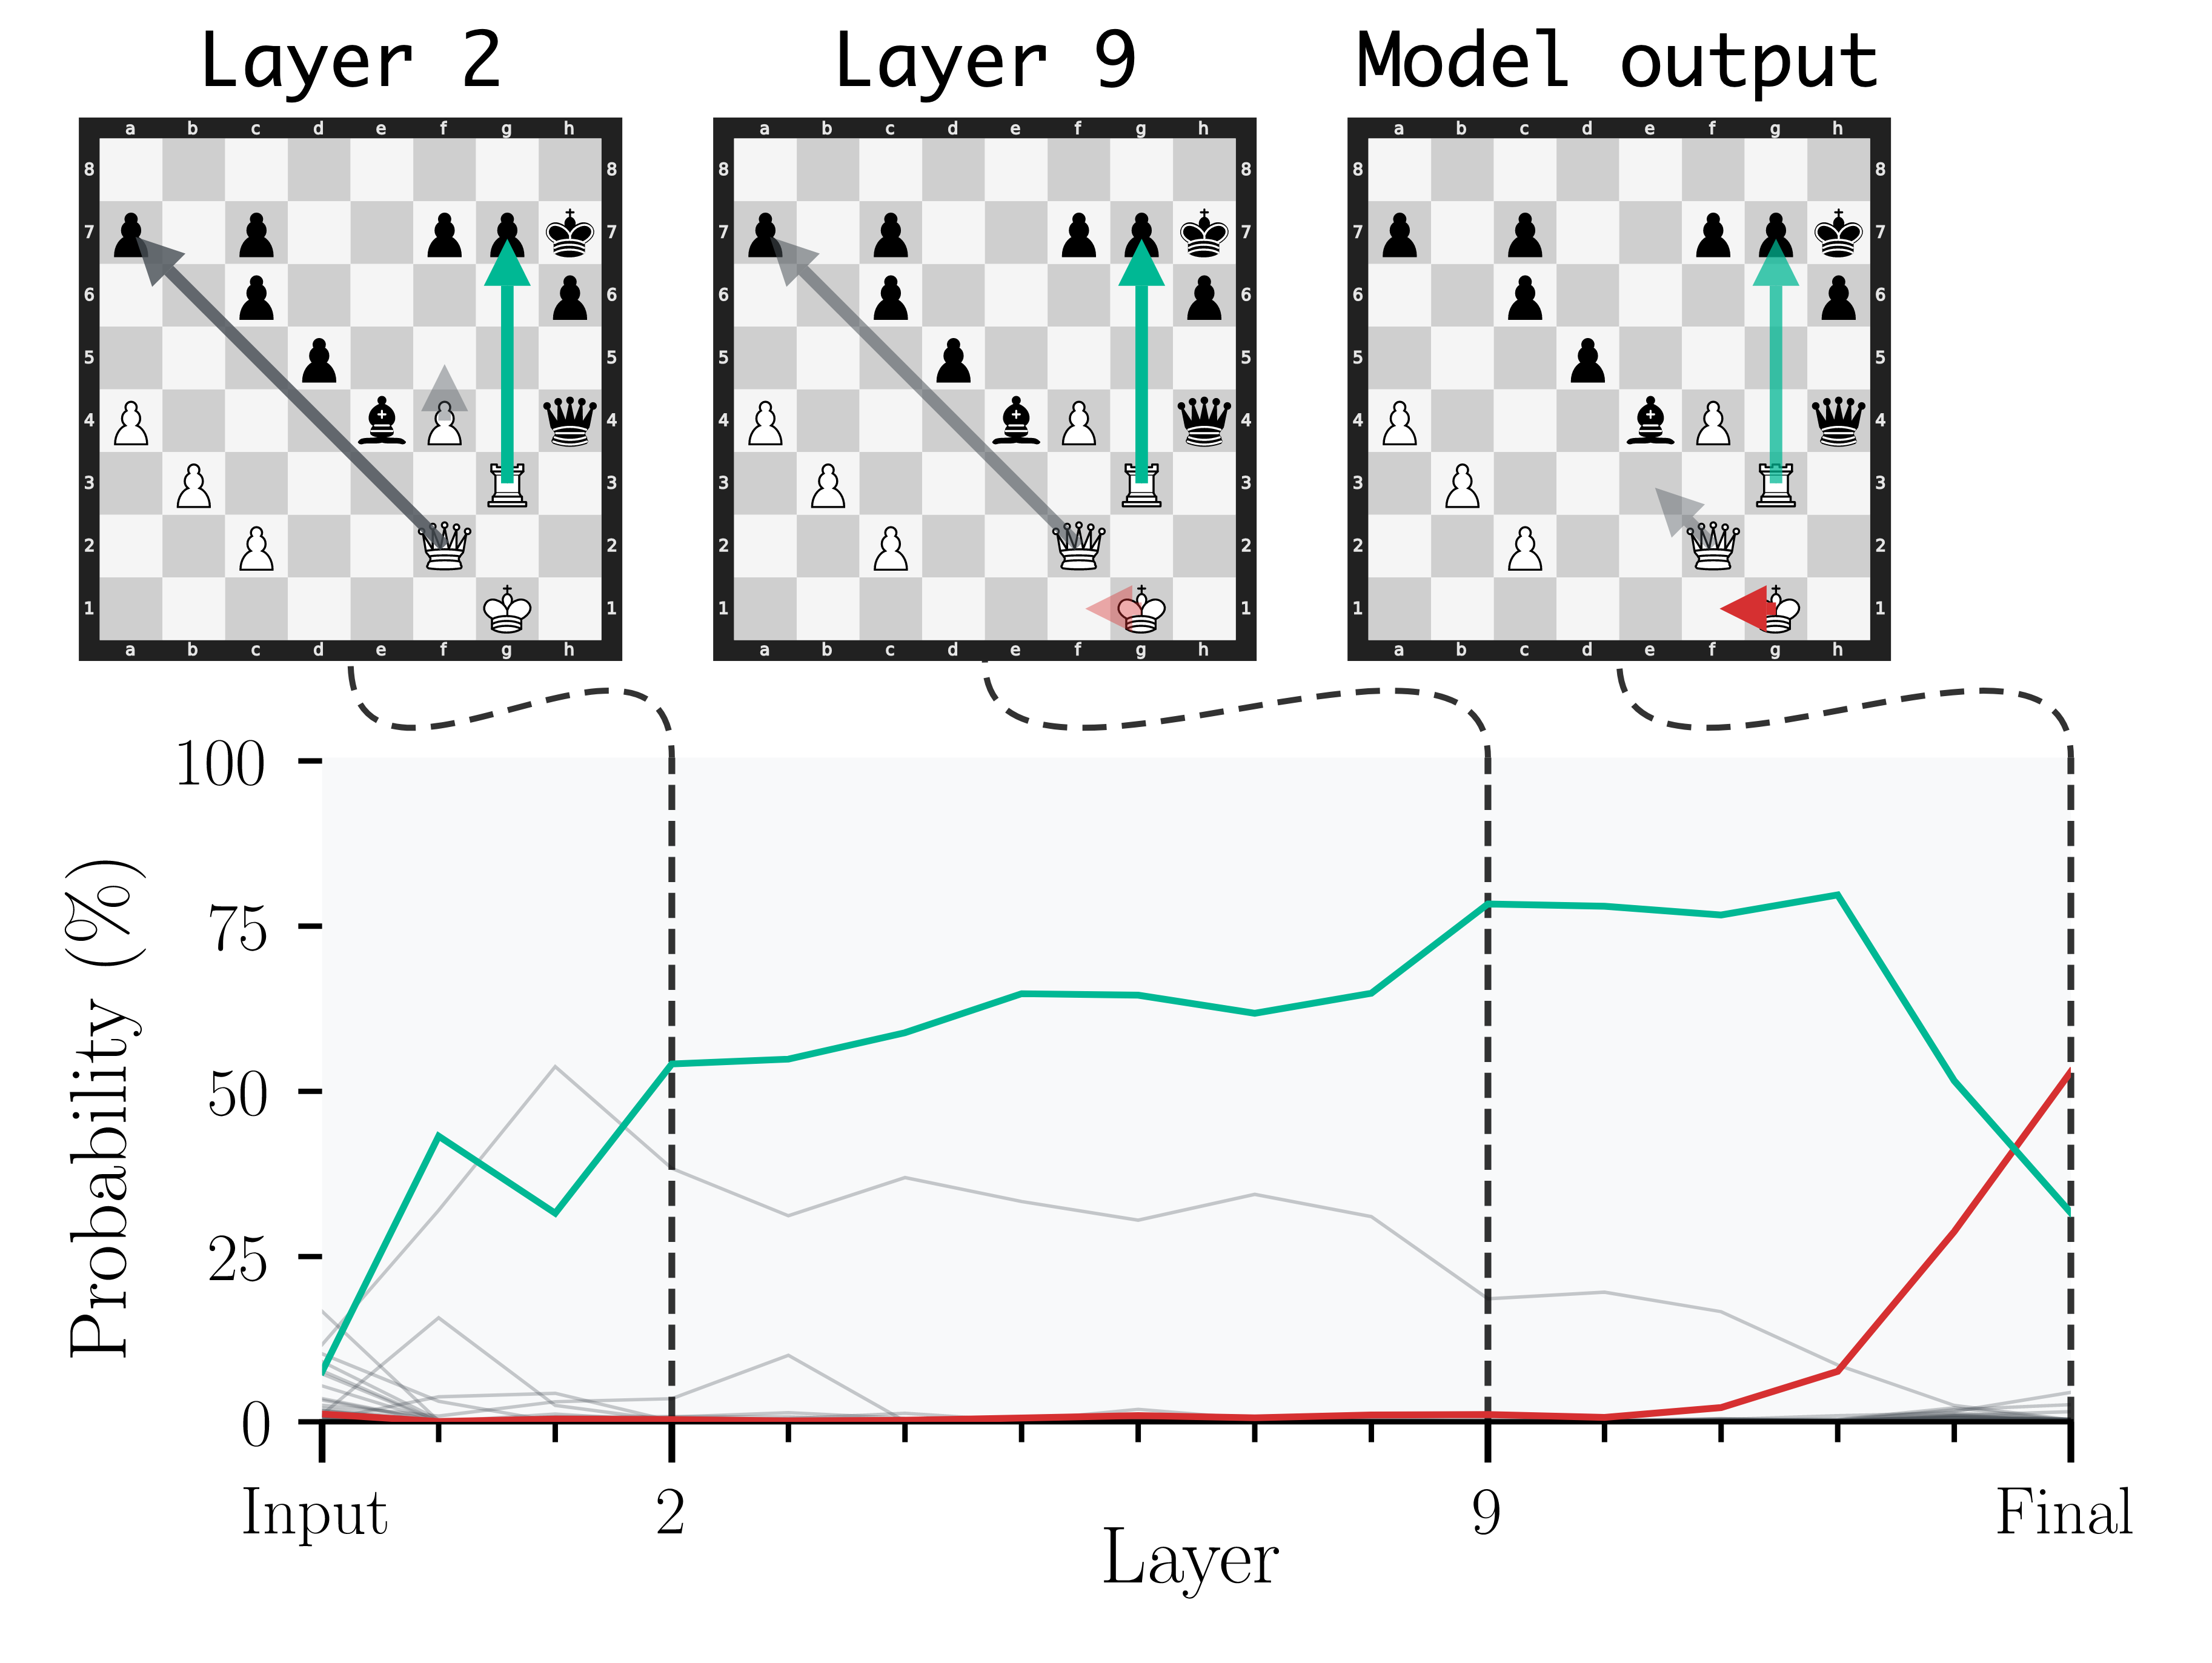

In [16]:
print("\nArranging boards with trajectory plot...")

# Scale the trajectory plot
plot_scaled = plot_ice.scale(9)

# Shift boards to the left to align with probability label
boards_row_shifted = boards_row.pad_right(400)  # Add padding on right to shift left

# Position trajectory BELOW the boards
combined_scene = plot_scaled.next_to(boards_row_shifted, ice.UP * 30)

# Now add dashed lines connecting from trajectory to boards
connect_path_style = ice.PathStyle(
    color=ice.BLACK, 
    thickness=10, 
    dashed=True, 
    dash_intervals=(40, 25),  # Increased from (5, 5) to match thickness
    dash_phase=-500
)

d = 300  # control point distance for bezier curves

with combined_scene:
    for layer_idx, board_snapshot in zip(board_layers, board_snapshots):
        # Get y_max from the plot axes
        ax = plot_ice.figure.axes[0]
        y_min, y_max = ax.get_ylim()
        
        # Start point: top of vertical line on trajectory (at y_max)
        sx, sy = plot_ice.axes_coordinates(layer_idx, y_max)
        
        # End point: bottom middle of board
        ex, ey = board_snapshot.relative_bounds.bottom_middle
        
        # Create curved line connecting them
        combined_scene += ice.CubicBezier(
            points=[(sx, sy), (sx, sy - d), (ex, ey + d), (ex, ey)],
            path_style=connect_path_style,
        ).opacity(0.8)

print("\nConnected boards to trajectory!")

# Display the combined scene
scene = combined_scene.pad(10).background(ice.WHITE)
scene

### STEP 4: ADD LEGEND


Creating legend...

Legend added!


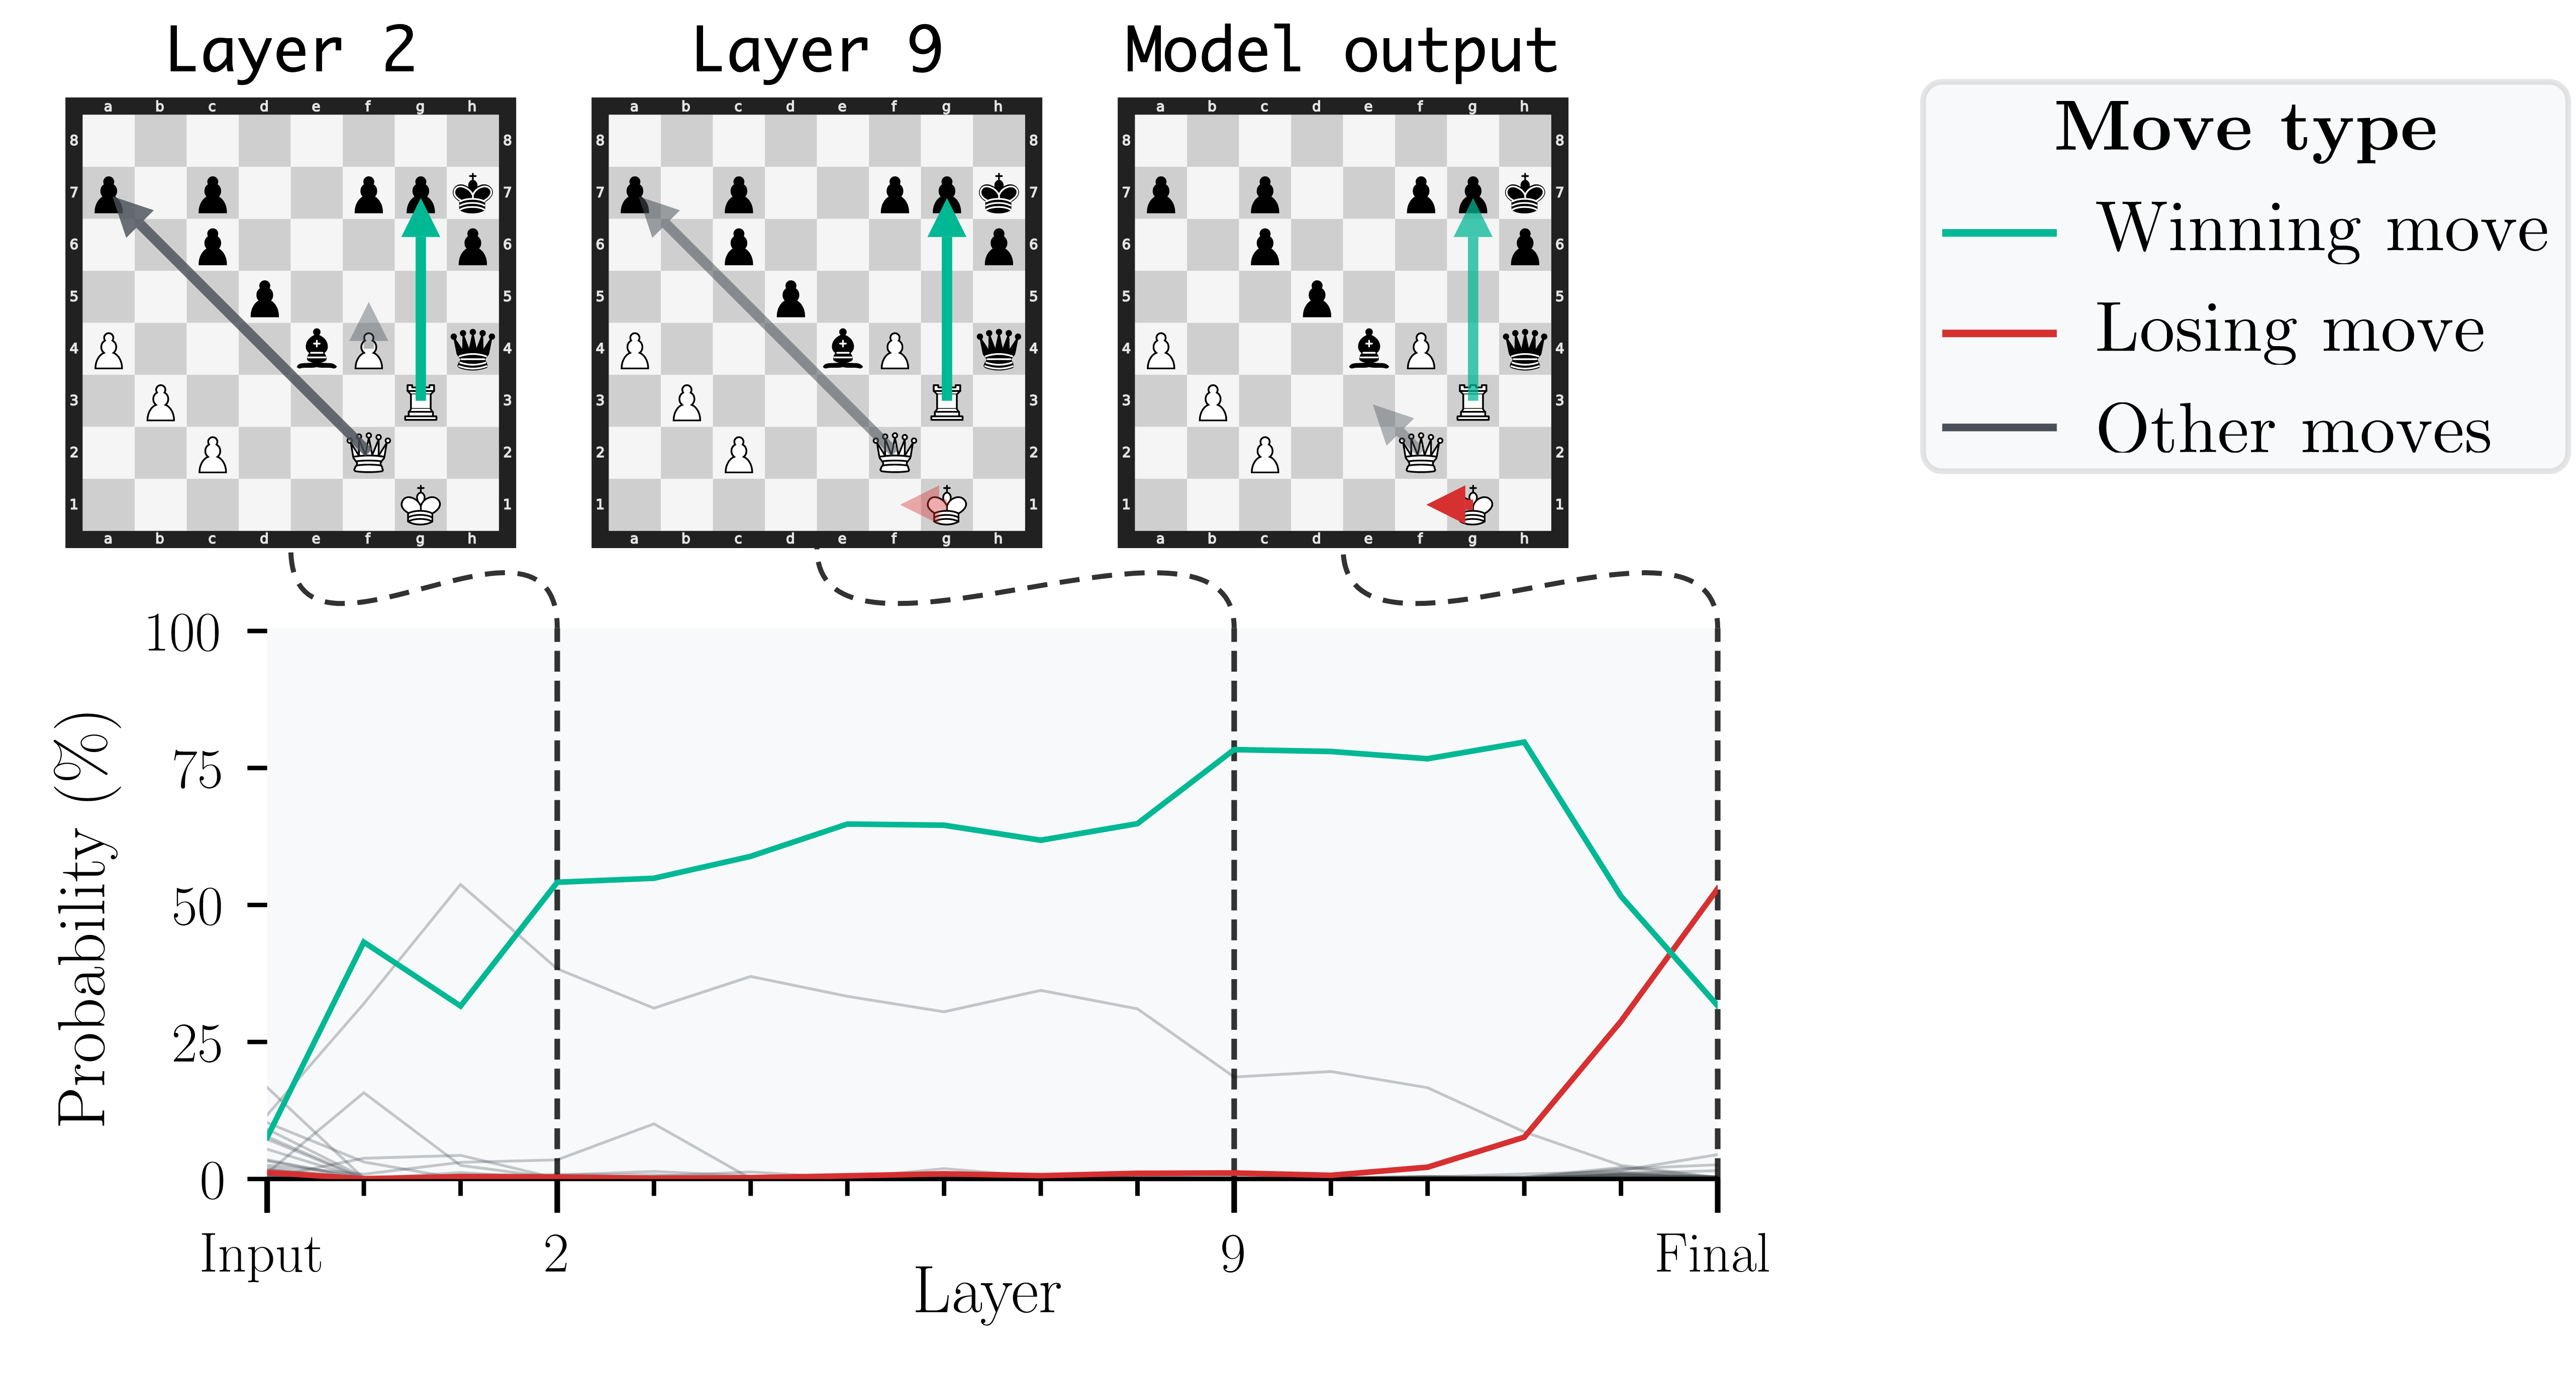

In [17]:
print("\nCreating legend...")

# Legend items
legend_items = [
    "Winning move",
    "Losing move",
    "Other moves",
]

legend_line_length = 60
legend_line_thickness = 4

# Create legend lines with appropriate colors
legend_lines = [
    ice.Line(
        (0, 0),
        (legend_line_length, 0),
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),  # Green
            thickness=legend_line_thickness
        ),
    ),
    ice.Line(
        (0, 0),
        (legend_line_length, 0),
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),  # Red
            thickness=legend_line_thickness
        ),
    ),
    ice.Line(
        (0, 0),
        (legend_line_length, 0),
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[3]),  # Grey
            thickness=legend_line_thickness
        ),
    ),
]

# Create legend texts
legend_texts = [ice.Tex(tex=text).scale(3) for text in legend_items]

# Combine lines and texts
legend_lines_and_texts = [
    ice.Arrange([line, text], gap=20, arrange_direction=ice.HORIZONTAL)
    for line, text in zip(legend_lines, legend_texts)
]

# Stack legend items vertically
legend_contents = legend_lines_and_texts[0]
for i in range(1, len(legend_lines_and_texts)):
    legend_contents += (
        legend_lines_and_texts[i]
        .pad_top(20)
        .relative_to(legend_contents, ice.TOP_LEFT, ice.BOTTOM_LEFT)
    )

# Add legend title (matching example style)
legend_title = ice.Tex(tex="\\textbf{Move type}").scale(3)
legend_contents = ice.Arrange(
    [legend_title, legend_contents], gap=20, arrange_direction=ice.VERTICAL
)

# Add background (exactly matching example)
legend_background = ice.Rectangle(
    legend_contents.pad(10).bounds,
    border_color=ice.BLACK.with_alpha(0.1),
    # fill_color=ice.BLACK.with_alpha(0.01),
    fill_color=ice.Color.from_hex(fh.PLOT_FACE_COLOR),
    border_thickness=3,
    border_radius=10,
)

legend = legend_background.add_centered(legend_contents).scale(3.8)

# Position legend at top right of the scene
with combined_scene:
    combined_scene += legend.relative_to(
        boards_row_shifted,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    ).move(300, 0)  # Move right from the boards

print("\nLegend added!")

# Display the combined scene
scene = combined_scene.pad(10).background(ice.WHITE)
scene

### STEP 5: CREATE RESULTING POSITION BOARDS


Creating resulting position boards...
  Created resulting position boards


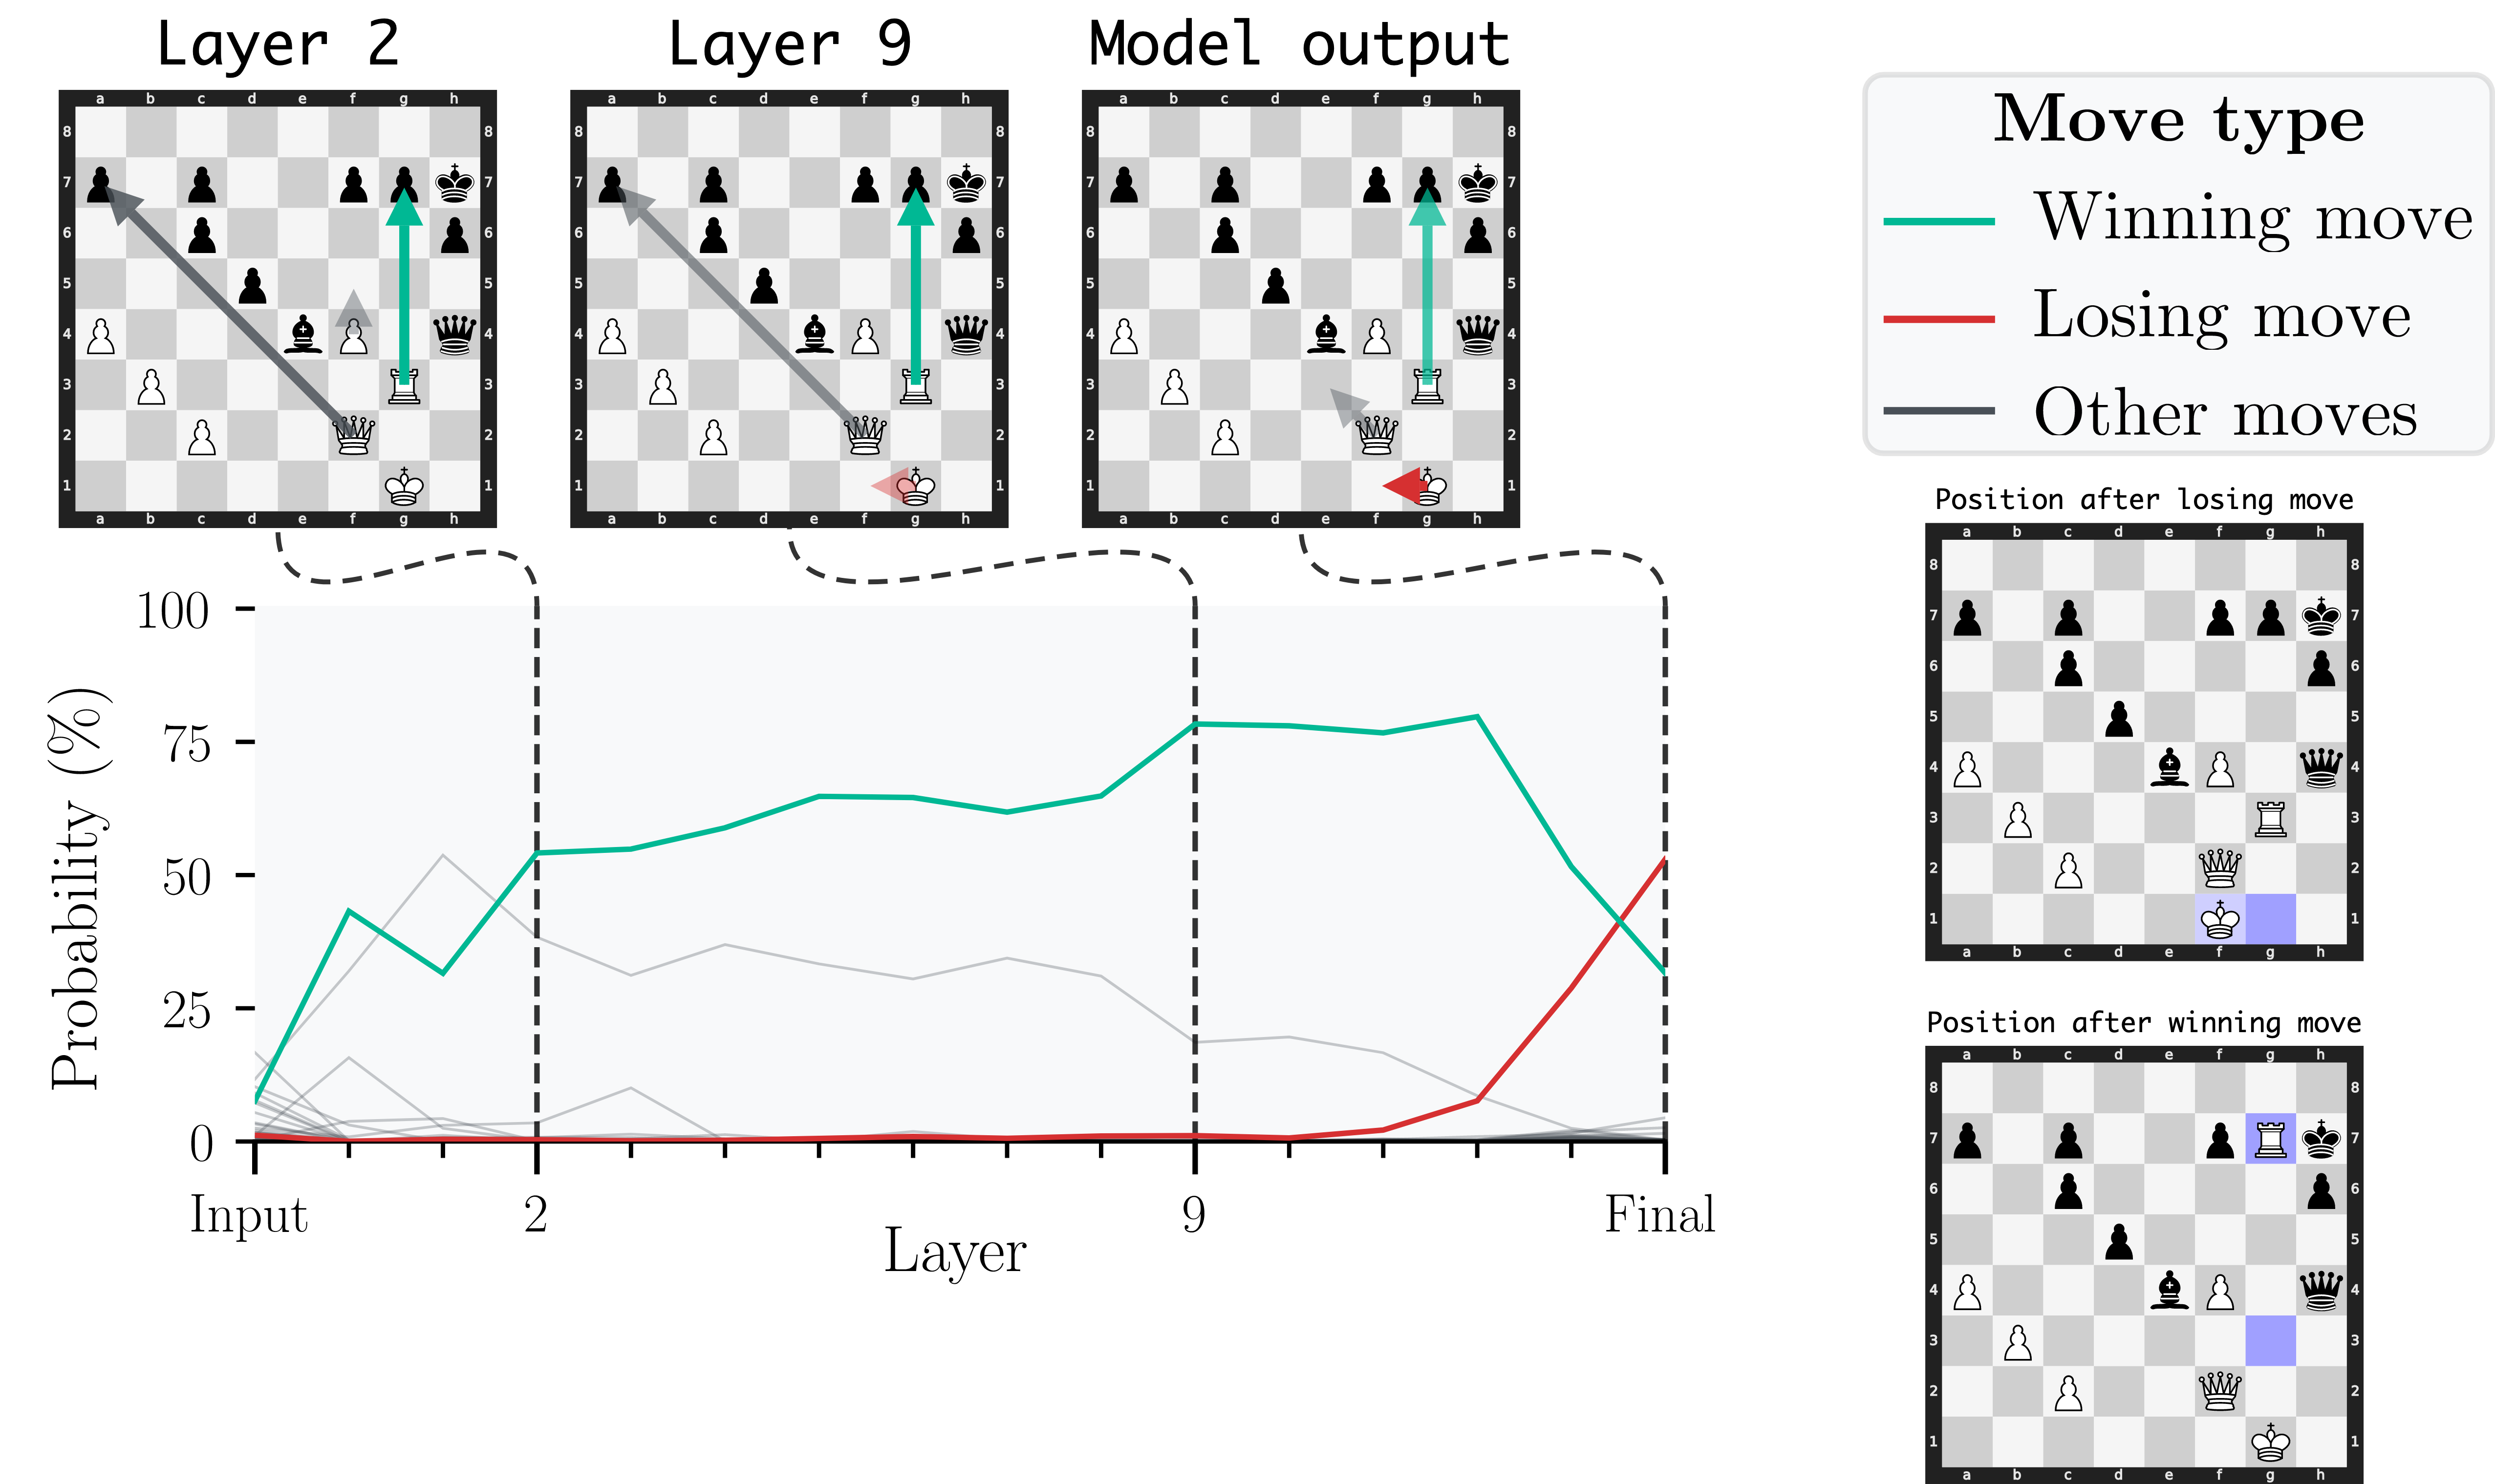

In [18]:
print("\nCreating resulting position boards...")

# Create copies of the board and play the winning and losing moves
board_after_winning = board.copy()
board_after_winning.push_uci(winning_move_uci)

board_after_losing = board.copy()
board_after_losing.push_uci(losing_move_uci)

# Create board plots (no arrows for now)
board_after_winning_plot = board_after_winning.plot(show_lastmove=True).scale(2.3)
board_after_losing_plot = board_after_losing.plot(show_lastmove=True).scale(2.3)

# Add titles above boards
title_winning = ice.Text("Position after winning move", ice.FontStyle("Monaco", size=55)).pad(10)
title_losing = ice.Text("Position after losing move", ice.FontStyle("Monaco", size=55)).pad(10)

# Arrange titles above boards
board_after_winning_with_title = title_winning + board_after_winning_plot.relative_to(
    title_winning, ice.TOP_MIDDLE, ice.BOTTOM_MIDDLE
)
board_after_losing_with_title = title_losing + board_after_losing_plot.relative_to(
    title_losing, ice.TOP_MIDDLE, ice.BOTTOM_MIDDLE
)

# Crop to remove extra whitespace
board_after_winning_with_title = board_after_winning_with_title.crop(board_after_winning_with_title.bounds)
board_after_losing_with_title = board_after_losing_with_title.crop(board_after_losing_with_title.bounds)

# Stack vertically (losing on top, winning on bottom)
resulting_boards = ice.Arrange(
    [board_after_losing_with_title, board_after_winning_with_title],
    gap=80,
    arrange_direction=ice.VERTICAL
)

print("  Created resulting position boards")

# Position resulting boards to the right of the trajectory plot
with combined_scene:
    combined_scene += resulting_boards.relative_to(
        plot_scaled,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    ).move(100, 0)  # Move right from the plot

combined_scene

### STEP 6: ADD DASHED LINES FROM TRAJECTORY TO RESULTING BOARDS


Connecting trajectory to resulting boards...

Connected trajectory to resulting boards!


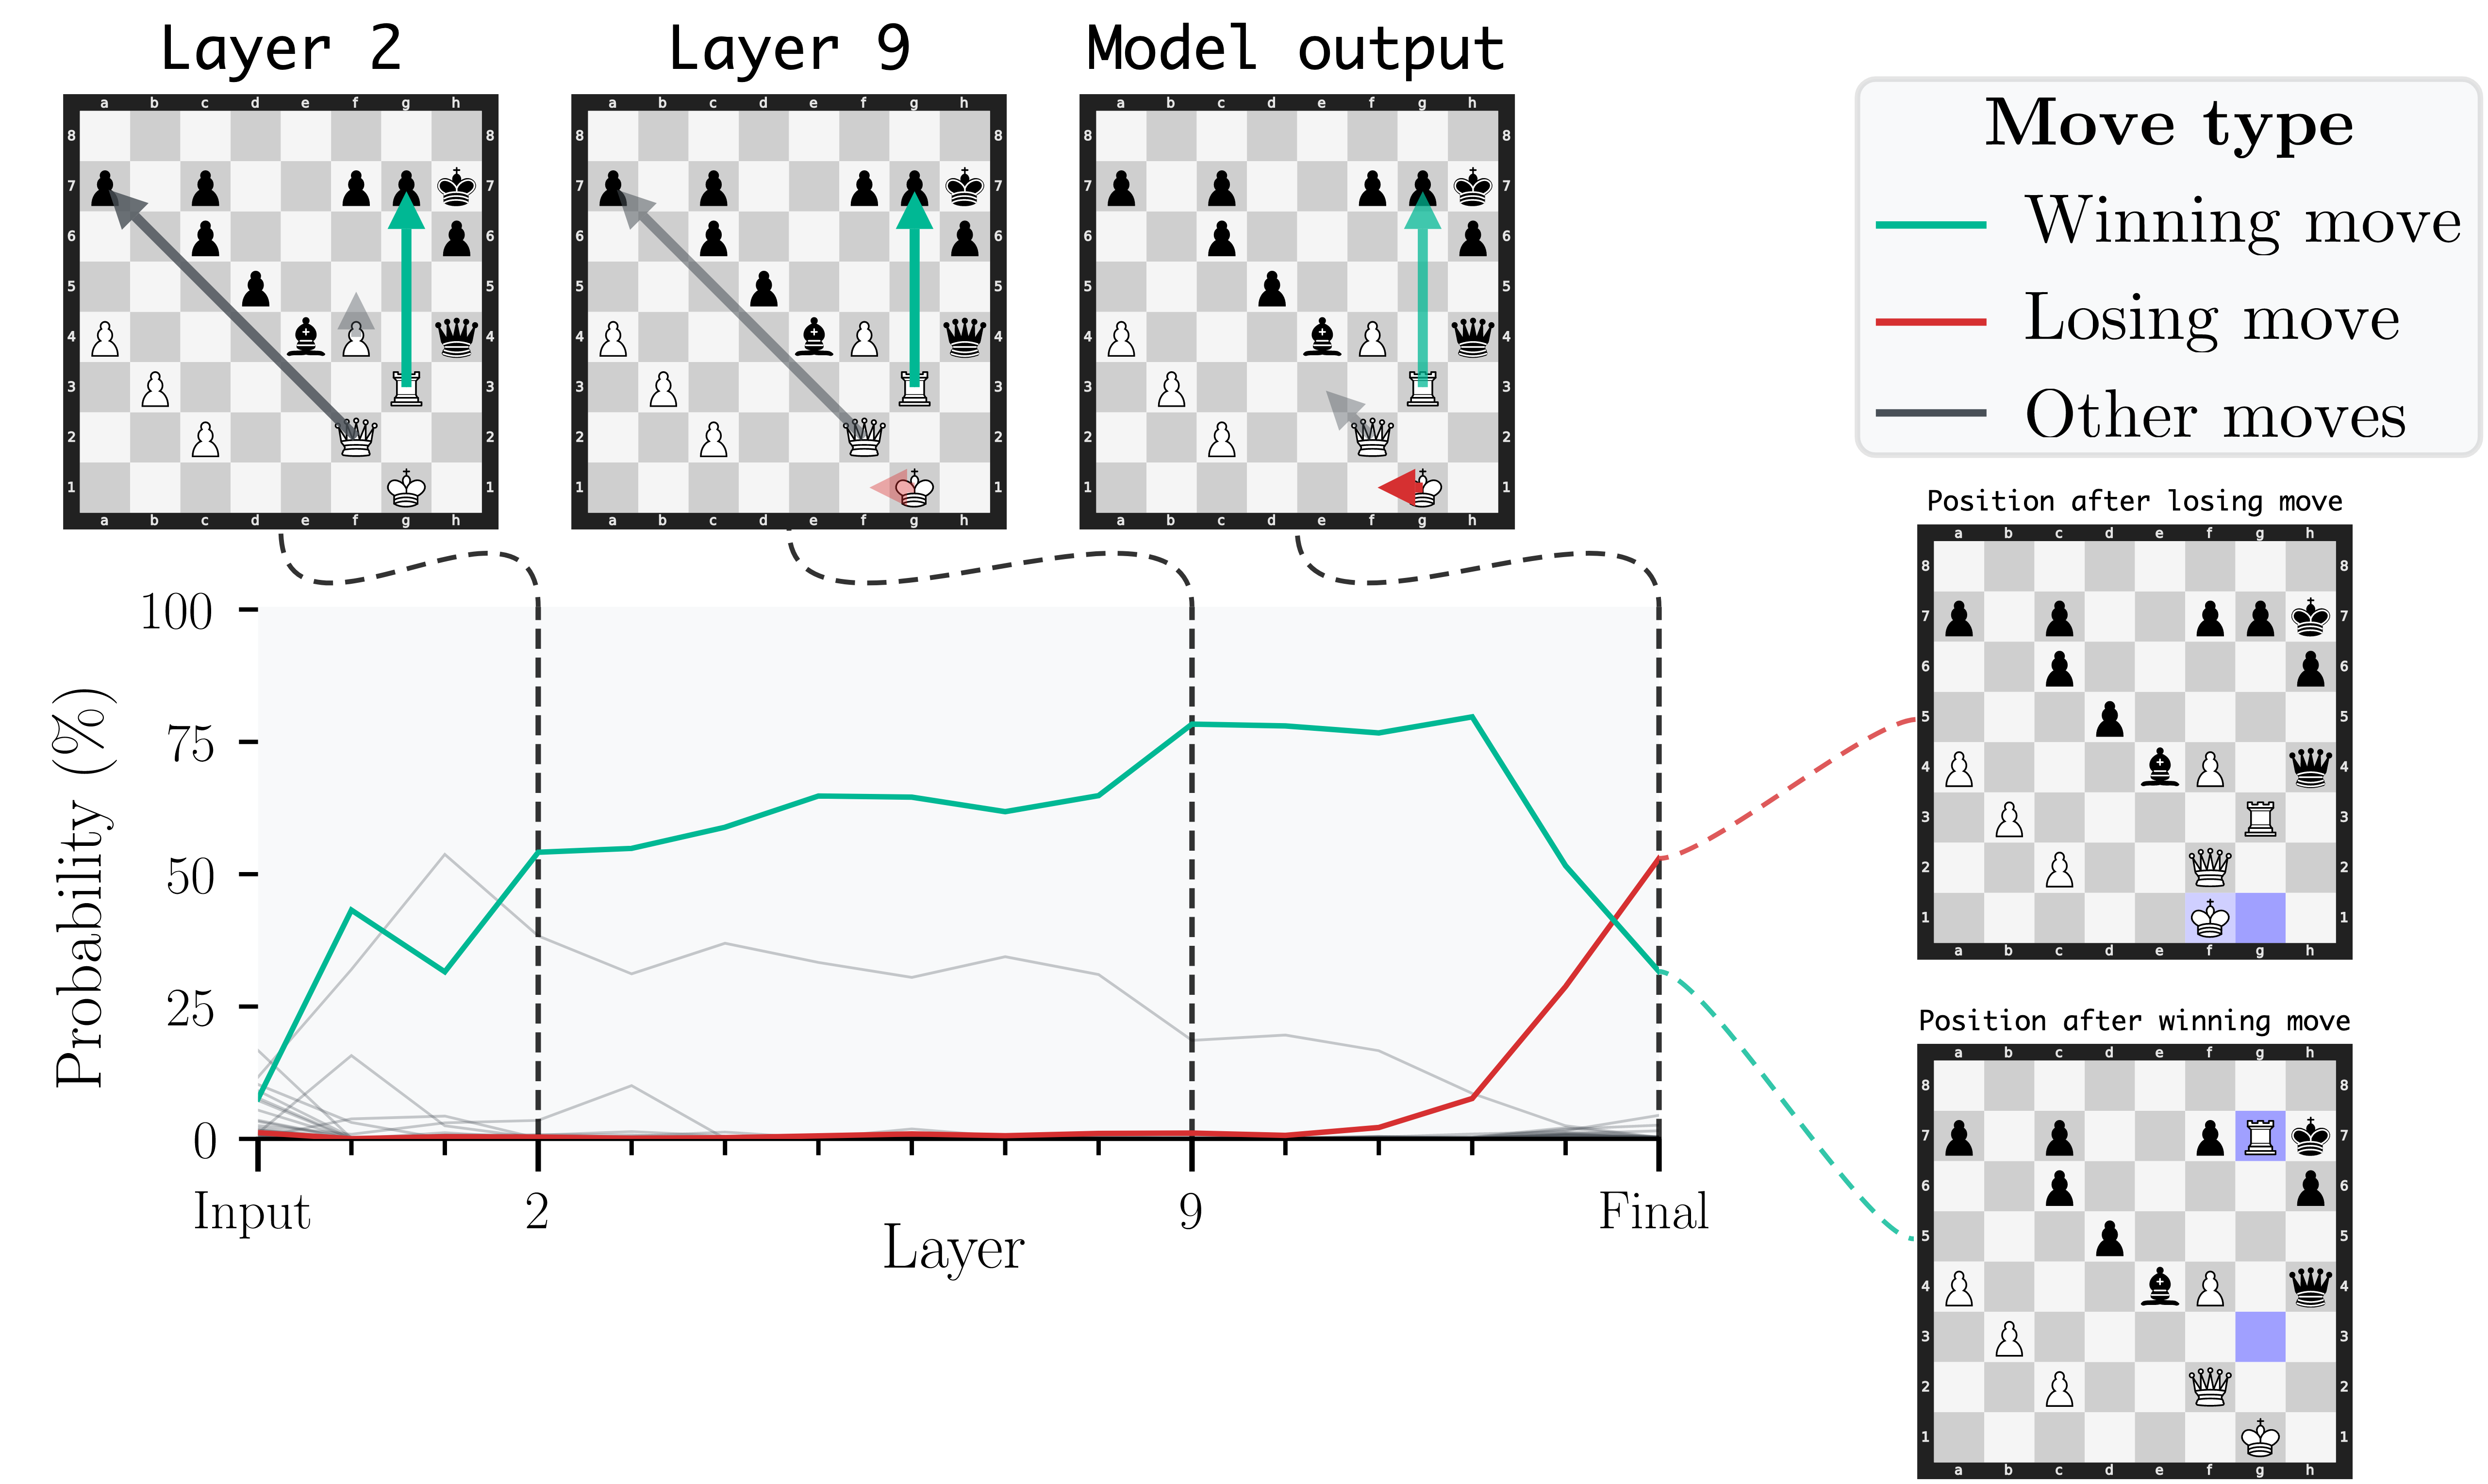

In [19]:
print("\nConnecting trajectory to resulting boards...")

# Get the final probabilities (at layer 15) for winning and losing moves
final_winning_prob = winning_trajectory[15]  # Probability at layer 15
final_losing_prob = losing_trajectory[15]    # Probability at layer 15

# Convert to percentage for axes coordinates (matching plot)
final_winning_prob_pct = final_winning_prob * 100
final_losing_prob_pct = final_losing_prob * 100

d_horizontal = 100  # control point distance for bezier curves

with combined_scene:
    # Red dashed line: from losing move trajectory to losing board
    ax = plot_ice.figure.axes[0]
    
    # Start point: end of red line at layer 15
    sx_losing, sy_losing = plot_ice.axes_coordinates(15, final_losing_prob_pct)
    
    # End point: left middle of losing board
    ex_losing, ey_losing = board_after_losing_with_title.relative_bounds.middle_left
    
    # Create curved red line
    combined_scene += ice.CubicBezier(
        points=[
            (sx_losing, sy_losing),
            (sx_losing + d_horizontal, sy_losing),
            (ex_losing - d_horizontal, ey_losing),
            (ex_losing, ey_losing)
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),  # Red
            thickness=10,
            dashed=True,
            dash_intervals=(40, 25),
            dash_phase=-500
        ),
    ).opacity(0.8)
    
    # Green dashed line: from winning move trajectory to winning board
    # Start point: end of green line at layer 15
    sx_winning, sy_winning = plot_ice.axes_coordinates(15, final_winning_prob_pct)
    
    # End point: left middle of winning board
    ex_winning, ey_winning = board_after_winning_with_title.relative_bounds.middle_left
    
    # Create curved green line
    combined_scene += ice.CubicBezier(
        points=[
            (sx_winning, sy_winning),
            (sx_winning + d_horizontal, sy_winning),
            (ex_winning - d_horizontal, ey_winning),
            (ex_winning, ey_winning)
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),  # Green
            thickness=10,
            dashed=True,
            dash_intervals=(40, 25),
            dash_phase=-500
        ),
    ).opacity(0.8)

print("\nConnected trajectory to resulting boards!")

# Display the combined scene
scene = combined_scene.pad(10).background(ice.WHITE)
scene


### STEP 7: ADD ARROWS AND WDL BARS

In [20]:
from iceberg import Arrow, PathStyle, ArrowHeadStyle

def add_board_edge_arrow(
    scene,
    board_drawable,
    color_hex,
    thickness=12,
    length=42,
    alpha=0.8,
    backshift=6,
):
    """
    Draw a short arrow pointing into the left edge of `board_drawable`.

    scene: the parent scene (combined_scene)
    board_drawable: e.g. board_losing_with_eval
    color_hex: fh.COLORS[2] (red) or fh.COLORS[0] (green)
    thickness: line thickness (also used to size head a bit)
    length: how long the shaft is to the left of the board
    backshift: how far away from the exact board edge the tip sits
    """

    # IMPORTANT: make coords float so Arrow doesn't choke on int -> float division
    start = (float(-length - backshift), float(0.0))
    end   = (float(-backshift),         float(0.0))

    arrow = Arrow(
        start=start,
        end=end,
        line_path_style=PathStyle(
            color=ice.Color.from_hex(color_hex),
            thickness=float(thickness),
        ),
        arrow_head_style=ArrowHeadStyle.FILLED_TRIANGLE,
        head_length=float(thickness * 3.2),
        # (you can also set arrow_head_end=True if you want head only at the end,
        # but FILLED_TRIANGLE already defaults to just the end)
    ).opacity(alpha)

    # Place arrow so that its (0,0) is anchored on the board's middle-left edge.
    # Because we drew it pointing right (→), this makes it look like an arrow
    # "feeding into" the board from the dashed curve.
    scene += arrow.relative_to(
        board_drawable,
        ice.MIDDLE_LEFT,   # anchor point on the board
        ice.MIDDLE_LEFT    # align arrow's own origin to that same point
    )

### Combine everything 


Adding evaluation components...
  WDL after winning move: W=99.5%, D=0.4%, L=0.1%
  WDL after losing move: W=0.9%, D=7.9%, L=91.1%

Rebuilding scene with evaluation components...

Evaluation components added!


/Users/hartig/PycharmProjects/leela-logit-lens-paper/venv/lib/python3.13/site-packages/onnx2torch/node_converters/slice.py:63: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_variable_indexing.cpp:312.)
  x = x[pos_axes_slices]


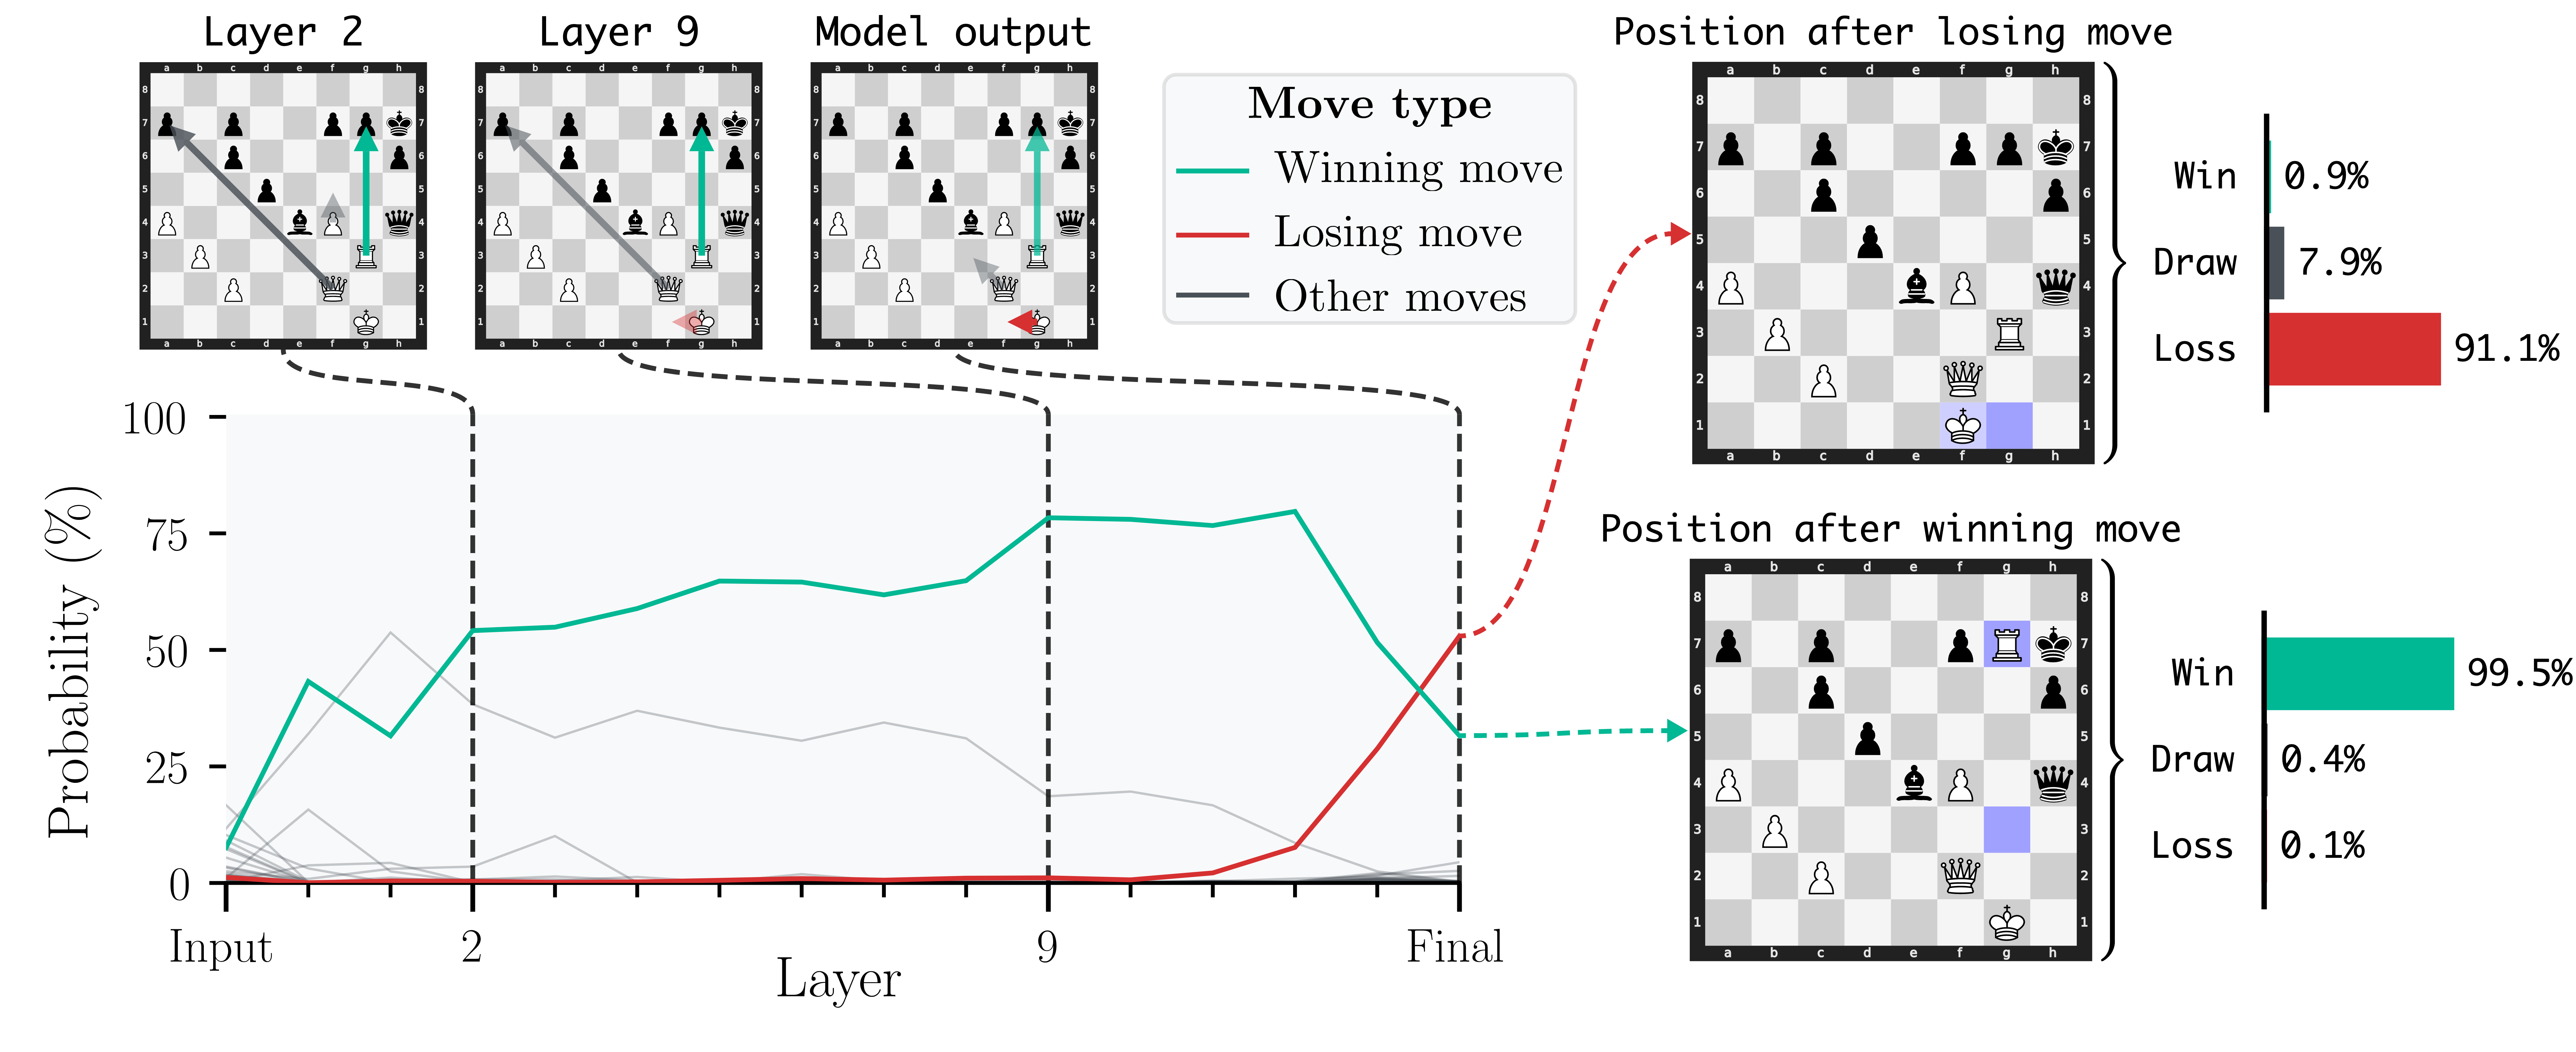

In [21]:
print("\nAdding evaluation components...")

from leela_logit_lens.tools.plotting_helpers import WDLBar

# Evaluate resulting positions with value head
def evaluate_position_wdl(board_position, model):
    """Get WDL evaluation for a position from the original player's perspective."""
    _, wdl, _ = model.play(board_position, return_probs=True)
    # After a move, the perspective is from the opponent's view
    # Flip to get it from original player's perspective: opponent's loss = our win
    return {
        'win': wdl[2] if isinstance(wdl[2], float) else wdl[2].item(),   # opponent's loss
        'draw': wdl[1] if isinstance(wdl[1], float) else wdl[1].item(),  # draw stays same
        'loss': wdl[0] if isinstance(wdl[0], float) else wdl[0].item(),  # opponent's win
    }

# Get WDL evaluations
wdl_after_winning = evaluate_position_wdl(board_after_winning, model)
wdl_after_losing = evaluate_position_wdl(board_after_losing, model)

print(f"  WDL after winning move: W={wdl_after_winning['win']:.1%}, D={wdl_after_winning['draw']:.1%}, L={wdl_after_winning['loss']:.1%}")
print(f"  WDL after losing move: W={wdl_after_losing['win']:.1%}, D={wdl_after_losing['draw']:.1%}, L={wdl_after_losing['loss']:.1%}")

# Create evaluation chain for both boards
def create_evaluation_chain(board_without_title, title, wdl_dict):
    """Create board -> brace -> WDL bar chain, then add title."""
    
    # Create brace (similar to Figure 1)
    brace_height = board_without_title.bounds.height
    evaluation_brace = ice.Brace(target_width=brace_height, target_height=50)
    evaluation_brace = ice.Transform(child=evaluation_brace, rotation=-90).pad_left(20).pad_right(20)
    
    # WDL bar
    wdl_bar = WDLBar(
        win_prob=wdl_dict['win'],
        draw_prob=wdl_dict['draw'],
        loss_prob=wdl_dict['loss'],
        bar_height=70,
        bar_width=25,
        label_font_family=fh.FONT_FAMILY,
    ).scale(6)
    
    # Start with board_without_title
    new_scene = board_without_title
    
    # Add brace to the right of board
    new_scene += evaluation_brace.relative_to(
        board_without_title,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    )
    
    # Add WDL bar to the right of brace - position relative to board with offset
    # Calculate offset: board width + brace width + some gap
    wdl_bar_offset = board_without_title.bounds.width + evaluation_brace.bounds.width + 40
    new_scene += wdl_bar.relative_to(
        board_without_title,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_LEFT
    ).move(wdl_bar_offset, 0)
    
    # Now add title above the board (not above the whole scene)
    new_scene += title.relative_to(
        board_without_title,
        ice.BOTTOM_MIDDLE,
        ice.TOP_MIDDLE
    )
    
    return new_scene

# Create titles
title_winning = ice.Text("Position after winning move", ice.FontStyle("Monaco", size=80)).pad(12)
title_losing = ice.Text("Position after losing move", ice.FontStyle("Monaco", size=80)).pad(12)

value_head_label = ice.Text("Value head", ice.FontStyle("Monaco", size=60)).pad(8)

# Create evaluation chains for both boards
board_losing_with_eval = create_evaluation_chain(board_after_losing_plot, title_losing, wdl_after_losing)
board_winning_with_eval = create_evaluation_chain(board_after_winning_plot, title_winning, wdl_after_winning)

# Stack them vertically (replacing the old resulting_boards)
resulting_boards_with_eval = ice.Arrange(
    [board_losing_with_eval, board_winning_with_eval],
    gap=80,
    arrange_direction=ice.VERTICAL
).scale(1.4)

# Remove old resulting_boards from scene and add new one
# We need to rebuild the scene
print("\nRebuilding scene with evaluation components...")

# Rebuild: boards at top, plot below, legend to the right
plot_scaled = plot_ice.scale(12)
boards_row_shifted = boards_row.pad_right(1000)
combined_scene = plot_scaled.next_to(boards_row_shifted, ice.UP * 30)

# Add connecting lines from boards to trajectory (same as before)
connect_path_style = ice.PathStyle(
    color=ice.BLACK, 
    thickness=15, 
    dashed=True, 
    dash_intervals=(50, 25),
    dash_phase=-500
)
d = 150

with combined_scene:
    for layer_idx, board_snapshot in zip(board_layers, board_snapshots):
        ax = plot_ice.figure.axes[0]
        y_min, y_max = ax.get_ylim()
        sx, sy = plot_ice.axes_coordinates(layer_idx, y_max)
        ex, ey = board_snapshot.relative_bounds.bottom_middle
        combined_scene += ice.CubicBezier(
            points=[(sx, sy), (sx, sy - d), (ex, ey + d), (ex, ey)],
            path_style=connect_path_style,
        ).opacity(0.8)

# Add legend
with combined_scene:
    combined_scene += legend.relative_to(
        boards_row_shifted,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    ).move(-800, 70)

# Add resulting boards with evaluation - align TOP of boards directly
with combined_scene:
    # Get the absolute top position of the first board snapshot in the scene
    first_snapshot_top = board_snapshots[0].relative_bounds.top
    
    # Get the absolute top position of the first resulting board (the actual board, not the titled version)
    # We need to find where board_after_losing_plot sits within resulting_boards_with_eval
    losing_board_top_in_container = board_after_losing_plot.relative_bounds.top
    resulting_container_top = resulting_boards_with_eval.relative_bounds.top
    
    # The offset from the container top to the actual board top
    offset_to_board = losing_board_top_in_container - resulting_container_top
    
    # Position the container such that the board aligns with snapshot top
    # We want: resulting_container_top + offset_to_board = first_snapshot_top
    # So: resulting_container_top = first_snapshot_top - offset_to_board
    
    combined_scene += resulting_boards_with_eval.relative_to(
        boards_row_shifted,
        ice.TOP_LEFT,
        ice.TOP_RIGHT
    ).move(550, 0)

# Add dashed lines from trajectory to resulting boards (same as before)
d_horizontal = 300

with combined_scene:
    ax = plot_ice.figure.axes[0]
    
    # ---- PARAMETERS ----
    line_thickness = 15
    dash_pattern = (40, 25)
    d_horizontal = 350  # horizontal curvature strength
    lose_offset = -260    # how much earlier the dashed line ends (so arrow fits)
    win_offset = -290
    back_offset = 60
    
    # === RED (losing move) ===
    sx_losing, sy_losing = plot_ice.axes_coordinates(15, final_losing_prob_pct)
    ex_losing, ey_losing = board_losing_with_eval.relative_bounds.middle_left
    
    # Move curve endpoint slightly left so arrow starts later
    curve_end_losing = (ex_losing - lose_offset - back_offset, ey_losing)
    
    # Dashed curve up to arrow base
    combined_scene += ice.CubicBezier(
        points=[
            (sx_losing, sy_losing),
            (sx_losing + d_horizontal, sy_losing),
            (curve_end_losing[0] - d_horizontal, curve_end_losing[1]),
            curve_end_losing
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),  # red
            thickness=line_thickness,
            dashed=True,
            dash_intervals=dash_pattern,
            dash_phase=-500,
        ),
    )# .opacity(0.8)
    
    # Solid arrow into board (red)
    arrow_red = Arrow(
        start=(-80.0, 0.0),
        end=(-6.0, 0.0),
        line_path_style=PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),
            thickness=line_thickness,
        ),
        arrow_head_style=ArrowHeadStyle.FILLED_TRIANGLE,
        head_length=line_thickness * 3.2,
    )# .opacity(0.8)
    combined_scene += arrow_red.relative_to(
        board_losing_with_eval,
        ice.MIDDLE_RIGHT,
        ice.MIDDLE_LEFT
    ).move(-lose_offset, 0)
    
    # === GREEN (winning move) ===
    sx_winning, sy_winning = plot_ice.axes_coordinates(15, final_winning_prob_pct)
    ex_winning, ey_winning = board_winning_with_eval.relative_bounds.middle_left
    
    curve_end_winning = (ex_winning - win_offset - back_offset, ey_winning)
    
    # Dashed curve up to arrow base
    combined_scene += ice.CubicBezier(
        points=[
            (sx_winning, sy_winning),
            (sx_winning + d_horizontal, sy_winning),
            (curve_end_winning[0] - d_horizontal, curve_end_winning[1]),
            curve_end_winning
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),  # green
            thickness=line_thickness,
            dashed=True,
            dash_intervals=dash_pattern,
            dash_phase=-500,
        ),
    )# .opacity(0.8)
    
    # Solid arrow into board (green)
    arrow_green = Arrow(
        start=(-80.0, 0.0),
        end=(-6.0, 0.0),
        line_path_style=PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),
            thickness=line_thickness,
        ),
        arrow_head_style=ArrowHeadStyle.FILLED_TRIANGLE,
        head_length=line_thickness * 3.2,
    )# .opacity(0.8)
    combined_scene += arrow_green.relative_to(
        board_winning_with_eval,
        ice.MIDDLE_RIGHT,
        ice.MIDDLE_LEFT
    ).move(-win_offset, 0)

print("\nEvaluation components added!")

# Display the combined scene
scene = combined_scene.pad(10).background(ice.WHITE)
scene

In [22]:
scene.render("Figures/forgotten_puzzle_figure.pdf")

In [23]:
scene.render("Figures/forgotten_puzzle_figure.png")

In [24]:
scene.scale(3.0).render("Figures/forgotten_puzzle_figure_scale_3.png")

### Some annotation for poster


Adding evaluation components...
  WDL after winning move: W=99.5%, D=0.4%, L=0.1%
  WDL after losing move: W=0.9%, D=7.9%, L=91.1%

Rebuilding scene with evaluation components...

Evaluation components added!


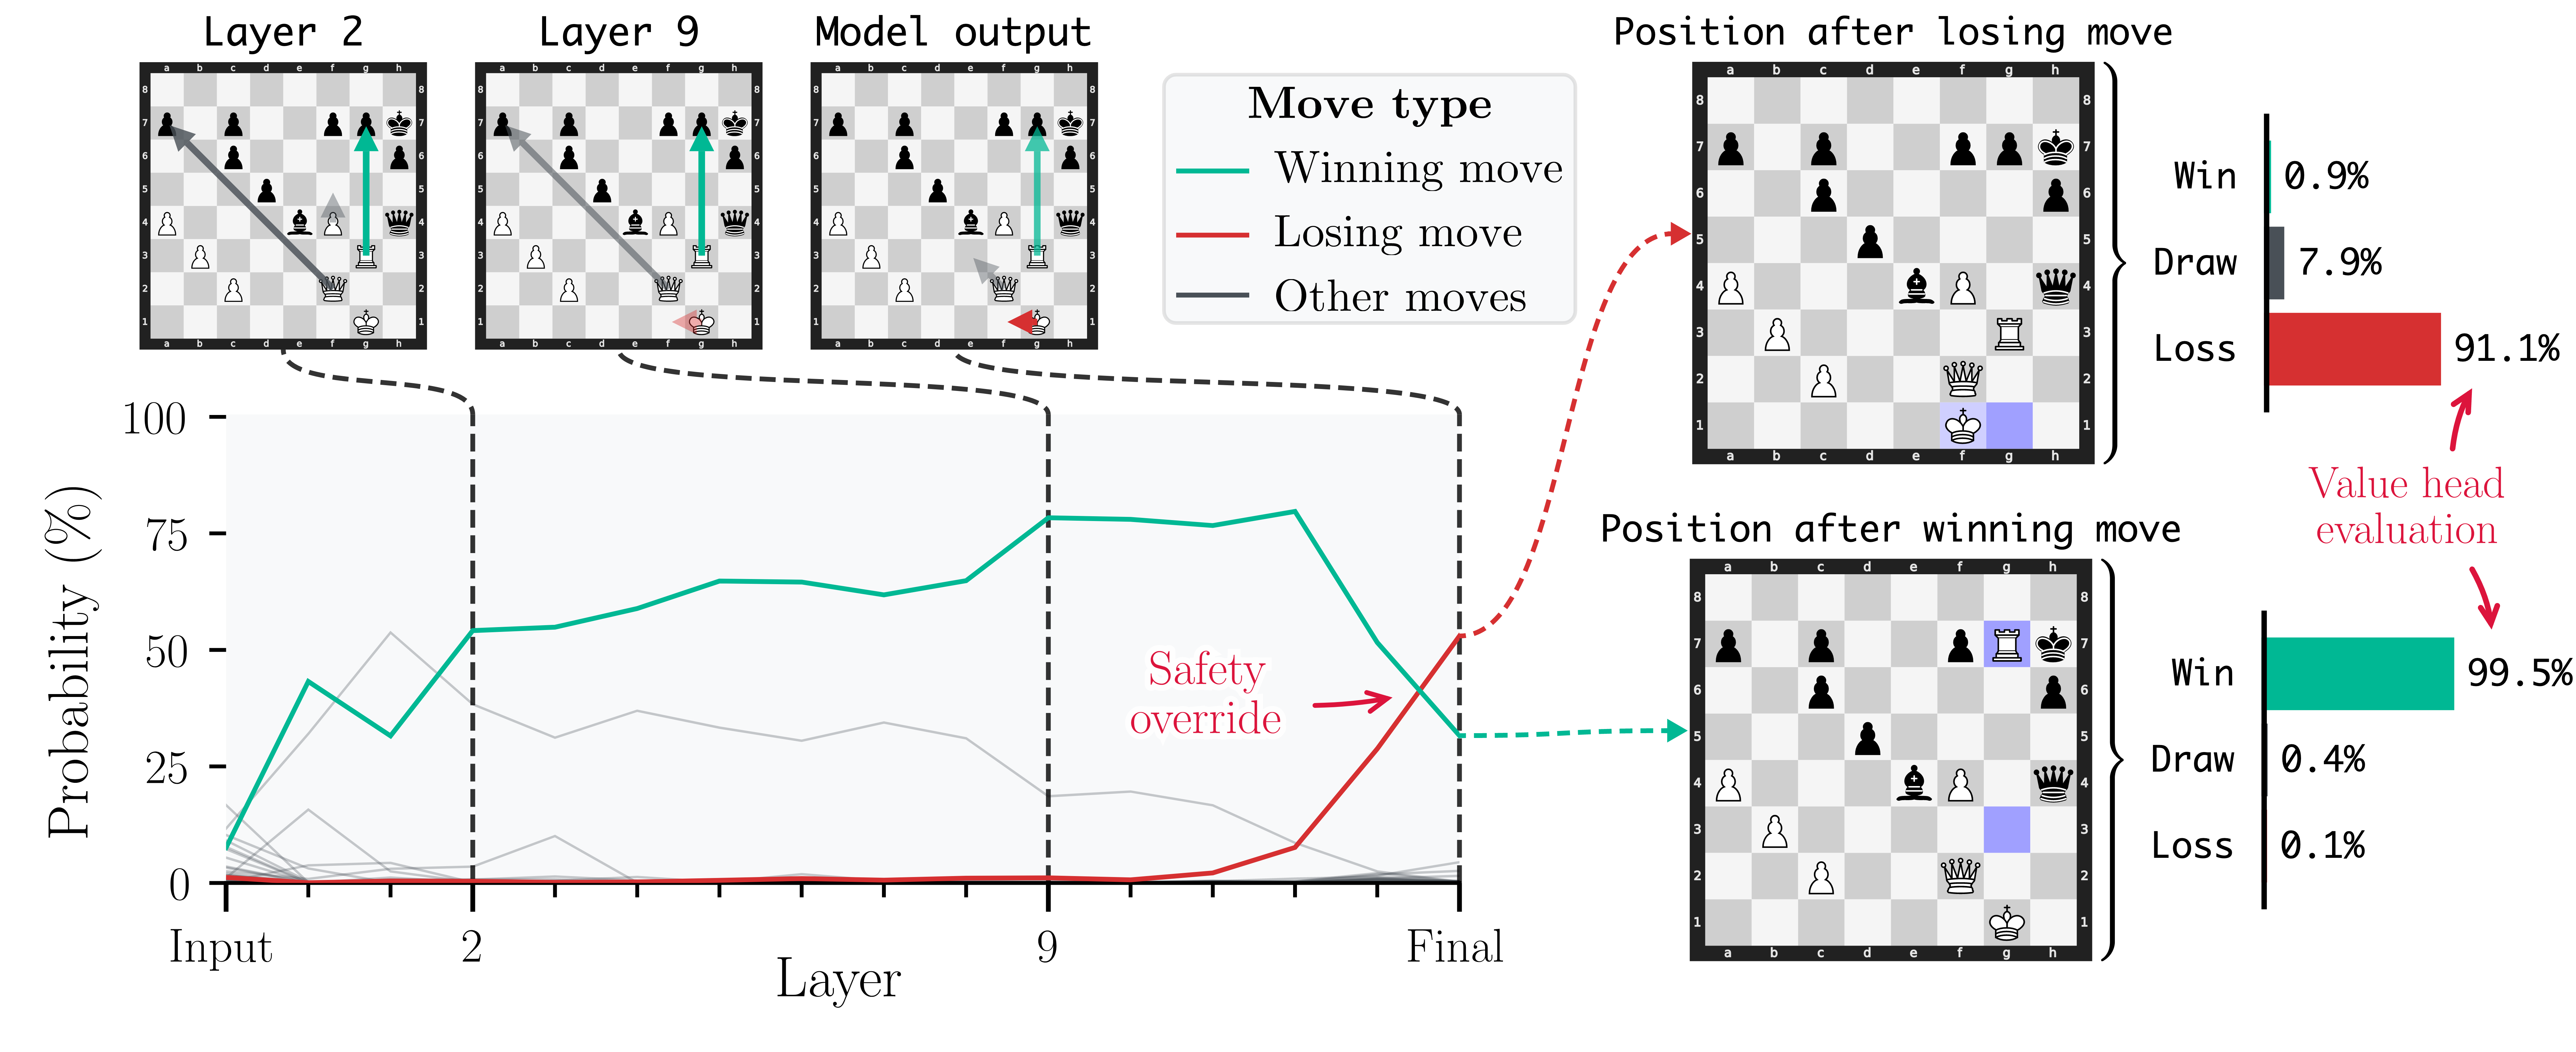

In [25]:
print("\nAdding evaluation components...")

from leela_logit_lens.tools.plotting_helpers import WDLBar

# Evaluate resulting positions with value head
def evaluate_position_wdl(board_position, model):
    """Get WDL evaluation for a position from the original player's perspective."""
    _, wdl, _ = model.play(board_position, return_probs=True)
    # After a move, the perspective is from the opponent's view
    # Flip to get it from original player's perspective: opponent's loss = our win
    return {
        'win': wdl[2] if isinstance(wdl[2], float) else wdl[2].item(),   # opponent's loss
        'draw': wdl[1] if isinstance(wdl[1], float) else wdl[1].item(),  # draw stays same
        'loss': wdl[0] if isinstance(wdl[0], float) else wdl[0].item(),  # opponent's win
    }

# Get WDL evaluations
wdl_after_winning = evaluate_position_wdl(board_after_winning, model)
wdl_after_losing = evaluate_position_wdl(board_after_losing, model)

print(f"  WDL after winning move: W={wdl_after_winning['win']:.1%}, D={wdl_after_winning['draw']:.1%}, L={wdl_after_winning['loss']:.1%}")
print(f"  WDL after losing move: W={wdl_after_losing['win']:.1%}, D={wdl_after_losing['draw']:.1%}, L={wdl_after_losing['loss']:.1%}")

# Create evaluation chain for both boards
def create_evaluation_chain(board_without_title, title, wdl_dict):
    """Create board -> brace -> WDL bar chain, then add title."""
    
    # Create brace (similar to Figure 1)
    brace_height = board_without_title.bounds.height
    evaluation_brace = ice.Brace(target_width=brace_height, target_height=50)
    evaluation_brace = ice.Transform(child=evaluation_brace, rotation=-90).pad_left(20).pad_right(20)
    
    # WDL bar
    wdl_bar = WDLBar(
        win_prob=wdl_dict['win'],
        draw_prob=wdl_dict['draw'],
        loss_prob=wdl_dict['loss'],
        bar_height=70,
        bar_width=25,
        label_font_family=fh.FONT_FAMILY,
    ).scale(6)
    
    # Start with board_without_title
    new_scene = board_without_title
    
    # Add brace to the right of board
    new_scene += evaluation_brace.relative_to(
        board_without_title,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    )
    
    # Add WDL bar to the right of brace - position relative to board with offset
    # Calculate offset: board width + brace width + some gap
    wdl_bar_offset = board_without_title.bounds.width + evaluation_brace.bounds.width + 40
    new_scene += wdl_bar.relative_to(
        board_without_title,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_LEFT
    ).move(wdl_bar_offset, 0)
    
    # Now add title above the board (not above the whole scene)
    new_scene += title.relative_to(
        board_without_title,
        ice.BOTTOM_MIDDLE,
        ice.TOP_MIDDLE
    )
    
    return new_scene

# Create titles
title_winning = ice.Text("Position after winning move", ice.FontStyle("Monaco", size=80)).pad(12)
title_losing = ice.Text("Position after losing move", ice.FontStyle("Monaco", size=80)).pad(12)

value_head_label = ice.Text("Value head", ice.FontStyle("Monaco", size=60)).pad(8)

# Create evaluation chains for both boards
board_losing_with_eval = create_evaluation_chain(
    board_after_losing_plot, 
    title_losing, 
    wdl_after_losing,
)
board_winning_with_eval = create_evaluation_chain(
    board_after_winning_plot, 
    title_winning, 
    wdl_after_winning,
)
# Stack them vertically (replacing the old resulting_boards)
resulting_boards_with_eval = ice.Arrange(
    [board_losing_with_eval, board_winning_with_eval],
    gap=80,
    arrange_direction=ice.VERTICAL
).scale(1.4)

# Remove old resulting_boards from scene and add new one
# We need to rebuild the scene
print("\nRebuilding scene with evaluation components...")

# Rebuild: boards at top, plot below, legend to the right
plot_scaled = plot_ice_annotated.scale(12)
boards_row_shifted = boards_row.pad_right(1000)
combined_scene = plot_scaled.next_to(boards_row_shifted, ice.UP * 30)

# Add connecting lines from boards to trajectory (same as before)
connect_path_style = ice.PathStyle(
    color=ice.BLACK, 
    thickness=15, 
    dashed=True, 
    dash_intervals=(50, 25),
    dash_phase=-500
)
d = 150

with combined_scene:
    for layer_idx, board_snapshot in zip(board_layers, board_snapshots):
        ax = plot_ice_annotated.figure.axes[0]
        y_min, y_max = ax.get_ylim()
        sx, sy = plot_ice_annotated.axes_coordinates(layer_idx, y_max)
        ex, ey = board_snapshot.relative_bounds.bottom_middle
        combined_scene += ice.CubicBezier(
            points=[(sx, sy), (sx, sy - d), (ex, ey + d), (ex, ey)],
            path_style=connect_path_style,
        ).opacity(0.8)

# Add legend
with combined_scene:
    combined_scene += legend.relative_to(
        boards_row_shifted,
        ice.MIDDLE_LEFT,
        ice.MIDDLE_RIGHT
    ).move(-800, 70)

# Add resulting boards with evaluation - align TOP of boards directly
with combined_scene:
    # Get the absolute top position of the first board snapshot in the scene
    first_snapshot_top = board_snapshots[0].relative_bounds.top
    
    # Get the absolute top position of the first resulting board (the actual board, not the titled version)
    # We need to find where board_after_losing_plot sits within resulting_boards_with_eval
    losing_board_top_in_container = board_after_losing_plot.relative_bounds.top
    resulting_container_top = resulting_boards_with_eval.relative_bounds.top
    
    # The offset from the container top to the actual board top
    offset_to_board = losing_board_top_in_container - resulting_container_top
    
    # Position the container such that the board aligns with snapshot top
    # We want: resulting_container_top + offset_to_board = first_snapshot_top
    # So: resulting_container_top = first_snapshot_top - offset_to_board
    
    combined_scene += resulting_boards_with_eval.relative_to(
        boards_row_shifted,
        ice.TOP_LEFT,
        ice.TOP_RIGHT
    ).move(550, 0)

# Add dashed lines from trajectory to resulting boards (same as before)
d_horizontal = 300

with combined_scene:
    ax = plot_ice_annotated.figure.axes[0]
    
    # ---- PARAMETERS ----
    line_thickness = 15
    dash_pattern = (40, 25)
    d_horizontal = 350  # horizontal curvature strength
    lose_offset = -260    # how much earlier the dashed line ends (so arrow fits)
    win_offset = -290
    back_offset = 60
    
    # === RED (losing move) ===
    sx_losing, sy_losing = plot_ice_annotated.axes_coordinates(15, final_losing_prob_pct)
    ex_losing, ey_losing = board_losing_with_eval.relative_bounds.middle_left
    
    # Move curve endpoint slightly left so arrow starts later
    curve_end_losing = (ex_losing - lose_offset - back_offset, ey_losing)
    
    # Dashed curve up to arrow base
    combined_scene += ice.CubicBezier(
        points=[
            (sx_losing, sy_losing),
            (sx_losing + d_horizontal, sy_losing),
            (curve_end_losing[0] - d_horizontal, curve_end_losing[1]),
            curve_end_losing
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),  # red
            thickness=line_thickness,
            dashed=True,
            dash_intervals=dash_pattern,
            dash_phase=-500,
        ),
    )# .opacity(0.8)
    
    # Solid arrow into board (red)
    arrow_red = Arrow(
        start=(-80.0, 0.0),
        end=(-6.0, 0.0),
        line_path_style=PathStyle(
            color=ice.Color.from_hex(fh.COLORS[2]),
            thickness=line_thickness,
        ),
        arrow_head_style=ArrowHeadStyle.FILLED_TRIANGLE,
        head_length=line_thickness * 3.2,
    )# .opacity(0.8)
    combined_scene += arrow_red.relative_to(
        board_losing_with_eval,
        ice.MIDDLE_RIGHT,
        ice.MIDDLE_LEFT
    ).move(-lose_offset, 0)
    
    # === GREEN (winning move) ===
    sx_winning, sy_winning = plot_ice_annotated.axes_coordinates(15, final_winning_prob_pct)
    ex_winning, ey_winning = board_winning_with_eval.relative_bounds.middle_left
    
    curve_end_winning = (ex_winning - win_offset - back_offset, ey_winning)
    
    # Dashed curve up to arrow base
    combined_scene += ice.CubicBezier(
        points=[
            (sx_winning, sy_winning),
            (sx_winning + d_horizontal, sy_winning),
            (curve_end_winning[0] - d_horizontal, curve_end_winning[1]),
            curve_end_winning
        ],
        path_style=ice.PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),  # green
            thickness=line_thickness,
            dashed=True,
            dash_intervals=dash_pattern,
            dash_phase=-500,
        ),
    )# .opacity(0.8)
    
    # Solid arrow into board (green)
    arrow_green = Arrow(
        start=(-80.0, 0.0),
        end=(-6.0, 0.0),
        line_path_style=PathStyle(
            color=ice.Color.from_hex(fh.COLORS[0]),
            thickness=line_thickness,
        ),
        arrow_head_style=ArrowHeadStyle.FILLED_TRIANGLE,
        head_length=line_thickness * 3.2,
    )# .opacity(0.8)
    combined_scene += arrow_green.relative_to(
        board_winning_with_eval,
        ice.MIDDLE_RIGHT,
        ice.MIDDLE_LEFT
    ).move(-win_offset, 0)

print("\nEvaluation components added!")

# Create a small matplotlib figure with "Value head" annotation and two arrows
fig_annotation, ax_annotation = plt.subplots(figsize=(2, 1.5), facecolor='none')
ax_annotation.set_xlim(0, 1)
ax_annotation.set_ylim(0, 1)
ax_annotation.axis('off')

# Text in the center
text_x = 0.7
text_y = 0.5

# Add text
text = ax_annotation.text(
    text_x, text_y,
    'Value head\nevaluation',
    fontsize=16,
    color='#DC143C',
    ha='center',
    va='center',
    zorder=20
)

# Add white outline to text
text.set_path_effects([
    pe.withStroke(linewidth=3.5, foreground="white", alpha=0.9)
])

# Arrow pointing UP from TOP of text (to top WDL bar)
ann_up = ax_annotation.annotate(
    '',  # No text, just arrow
    xy=(0.85, 0.9),  # Arrow tip (up and left)
    xytext=(text_x + 0.1, text_y + 0.2),  # Start from TOP-LEFT of text
    arrowprops=dict(
        arrowstyle='->',
        color='#DC143C',
        lw=2,
        shrinkA=0,
        shrinkB=0,
        mutation_scale=15,
        connectionstyle='arc3,rad=-0.1',

    ),
    zorder=20
)

# Arrow pointing DOWN from BOTTOM of text (to bottom WDL bar)
ann_down = ax_annotation.annotate(
    '',  # No text, just arrow
    xy=(0.9, 0.1),  # Arrow tip (down and left)
    xytext=(text_x + 0.15, text_y - 0.2),  # Start from BOTTOM-LEFT of text
    arrowprops=dict(
        arrowstyle='->',
        color='#DC143C',
        lw=2,
        shrinkA=0,
        shrinkB=0,
        mutation_scale=15,
        connectionstyle='arc3,rad=-0.1',

    ),
    zorder=20
)

fig_annotation.patch.set_alpha(0)
plt.tight_layout(pad=0)

# Convert to iceberg
value_head_annotation = ice.MatplotlibFigure(figure=fig_annotation)

# Add to your scene
with combined_scene:
    combined_scene += value_head_annotation.relative_to(
        resulting_boards_with_eval,
        ice.MIDDLE_RIGHT,
        ice.MIDDLE_LEFT
    ).move(1800, -600).scale(7)
    
# Display the combined scene
scene = combined_scene.pad(10)# .background(ice.WHITE)
scene

In [26]:
scene.scale(3.0).render("Figures/forgotten_puzzle_figure_transparent_scale_3_poster.png")